# **1.데이터 불러오기**

In [ ]:
# Mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
%matplotlib inline

In [ ]:
# Read Data
skt =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SK/skt.csv', index_col='Unnamed: 0')
ska = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SK/ska.csv', index_col='Unnamed: 0')

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

# **2.SK Telecom 제공 데이터 EDA**

### 데이터 기본 정보 확인

- SKA = 연령 및 성별 유동인구
- SKT = 시간대별 유동인구

HDONG_CD (행정동코드) 범주
- 11140: 서울 중구
- 11350: 서울 노원구
- 27110: 대구 중구
- 27260: 대구 수성구

In [ ]:
# dtype (int -> datetime) 변경
# index 설정 및 통합 data 만들기
skt_backup = skt
skt['STD_YMD'] = pd.to_datetime(skt['STD_YMD'].astype(str), format='%Y%m%d') # dtype datetime으로 변경
skt = skt.set_index(['HDONG_NM', 'STD_YMD']) # index로 설정

ska_backup = ska
ska['STD_YMD'] = pd.to_datetime(ska['STD_YMD'].astype(str), format='%Y%m%d') # dtype datetime으로 변경
ska = ska.set_index(['HDONG_NM', 'STD_YMD']) # index로 설정

sk = pd.concat([skt, ska.iloc[:,4:]], axis=1)
sk_backup = sk

In [ ]:
# 다시 나누기
skt = skt_backup
skt = skt.set_index('STD_YMD', drop=False)

ska = ska_backup
ska = ska.set_index('STD_YMD', drop=False)

skt.head()

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,TMST_10,TMST_11,TMST_12,TMST_13,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
STD_YMD,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-01,201902,2019-02-01,1114052000,소공동,1496.35,1022.83,706.51,547.77,1673.02,3561.05,9195.82,27927.16,36659.41,15892.56,12480.58,12096.82,12500.02,13618.87,12355.91,13096.69,9317.64,15029.74,14135.83,9074.02,6032.26,6047.05,4806.65,2956.11
2019-02-01,201902,2019-02-01,1114054000,회현동,1692.37,1117.26,839.57,653.41,1920.52,4687.95,10936.47,27383.48,34842.48,21441.33,16609.73,19362.36,19509.21,19403.78,18210.30,20292.65,12527.29,21454.63,18214.50,11914.26,9800.64,9341.24,6884.91,4034.56
2019-02-01,201902,2019-02-01,1114055000,명동,2226.91,1726.10,1145.43,894.97,2513.32,5268.51,13857.93,39968.76,51536.22,26487.78,20804.34,23616.10,22517.30,21384.24,20332.71,21458.64,14434.56,25855.14,23107.23,13460.05,9797.40,8719.30,7203.45,4845.48
2019-02-01,201902,2019-02-01,1114057000,필동,698.73,440.70,385.99,275.64,497.41,1990.42,4679.79,12538.27,15883.98,8645.99,6594.13,6798.58,7707.22,7429.62,6900.66,9789.54,6205.74,13277.25,12101.51,5698.58,4464.46,4088.53,3385.14,1746.28
2019-02-01,201902,2019-02-01,1114058000,장충동,768.34,447.23,429.90,349.46,507.74,1310.67,2956.49,6409.78,7850.42,4923.87,4608.90,5104.75,4671.02,4688.82,5187.02,5211.60,3656.54,6841.98,5810.71,4463.99,2807.25,2626.12,2415.41,1398.94


In [ ]:
# 구 정보 추가
temp = skt['HDONG_CD'].astype(str).str.slice(start=0, stop=5)
temp = temp.apply(lambda x: '서울 중구' if x == "11140" else x)
temp = temp.apply(lambda x: '서울 노원구' if x == "11350" else x)
temp = temp.apply(lambda x: '대구 중구' if x == "27110" else x)
temp = temp.apply(lambda x: '대구 수성구' if x == "27260" else x)
skt['HGU_NM'] = temp

In [ ]:
# 컬럼 순서 변경
skt = skt[['STD_YMD', 'STD_YM', 'HGU_NM', 'HDONG_CD', 'HDONG_NM', 'TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23']]
skt_backup1 = skt.copy()

In [ ]:
# 시간대 나누기
# 7-11 아침(TMST_MON) / 11-14 점심 / 14-18 오후 / 18-22 저녁 / 22-7 심야
skt['TMST_MORNING'] = np.mean(skt.iloc[:,13:17], axis=1)
skt['TMST_NOON'] = np.mean(skt.iloc[:,17:20], axis=1)
skt['TMST_AFTNOON'] = np.mean(skt.iloc[:,20:24], axis=1)
skt['TMST_NIGHT'] = np.mean(skt.iloc[:,24:28], axis=1)
skt['TMST_DAWN'] = np.mean(pd.concat([skt.iloc[:, 28:30], skt.iloc[:, 7:13]], axis=1), axis=1)

skt = skt[['STD_YMD', 'HGU_NM', 'HDONG_NM', 'TMST_MORNING', 'TMST_NOON', 'TMST_AFTNOON', 'TMST_NIGHT', 'TMST_DAWN']]
skt_backup2 = skt.copy()

### 서울 중구 주별 유동인구 평균 시계열 그래프 2019 vs 2020

- 매일은 보기 매우 힘들어서, 주별로 그림
- 동별 클러스터링이 필요
- 주별로 말고 자체 인덱스를 나눠서 (코로나 발발, 대구 시작, 마스크 배부 등의 인덱스 나눠서 하는 것도 해보기)

In [ ]:
# 데이터 만들기
def make_data(data, GU_NM):
    data_g = data[data.HGU_NM == GU_NM]
    data_g = data_g.resample('D').mean() # 클러스터링 하고 여기가 바껴야 함
    data_g = data_g.iloc[1:484]
    data_g = data_g.resample('W-Fri').mean()

    data_g_f = pd.concat([data_g.iloc[:17,].reset_index(), data_g.iloc[52:,].reset_index()], axis=1) # NA 행 지우고 연도별로 추출해야 일반화시켜야 쓰기 편할듯
    data_g_f.columns = ['STD_YMD_19', 'TMST_MORNING_19', 'TMST_NOON_19', 'TMST_AFTNOON_19', 'TMST_NIGHT_19', 'TMST_DAWN_19', 
                        'STD_YMD_20', 'TMST_MORNING_20', 'TMST_NOON_20', 'TMST_AFTNOON_20', 'TMST_NIGHT_20', 'TMST_DAWN_20']
    data_g_f.drop(['STD_YMD_19', 'STD_YMD_20'], axis=1,inplace=True)
    data_g_f.index = ['2-1', '2-2', '2-3', '2-4', '3-1', '3-2', '3-3', '3-4', '4-1', '4-2', '4-3', '4-4','4-5','5-1', '5-2', '5-3', '5-4']

    return data_g_f

In [ ]:
def issue_line(plot, min, mycolor):
    plot.axvline(x='2-3',color=mycolor,linestyle='--')
    plot.text('2-3',min,'신천지', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plot.axvline(x='3-2',color=mycolor,linestyle='--')
    plot.text('3-2',min, '마스크 5부제', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plot.axvline(x='3-4', color=mycolor,linestyle='--')
    plot.text('3-4',min, '사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plot.axvline(x='4-2', color=mycolor,linestyle='--')
    plot.text('4-1', min, '고강도 사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plot.axvline(x='5-1', color=mycolor,linestyle='--')
    plot.text('5-1',min,'생활속 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

In [ ]:
def issue_line2(min, mycolor):
    plt.axvline(x='2-3',color=mycolor,linestyle='--')
    plt.text('2-3',min,'신천지', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plt.axvline(x='3-2',color=mycolor,linestyle='--')
    plt.text('3-2',min, '마스크 5부제', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plt.axvline(x='3-4', color=mycolor,linestyle='--')
    plt.text('3-4',min, '사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plt.axvline(x='4-2', color=mycolor,linestyle='--')
    plt.text('4-2', min, '고강도 사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
    plt.axvline(x='5-1', color=mycolor,linestyle='--')
    plt.text('5-1',min,'생활속 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

In [ ]:
skt_sj_wm_f = make_data(skt, '서울 중구')

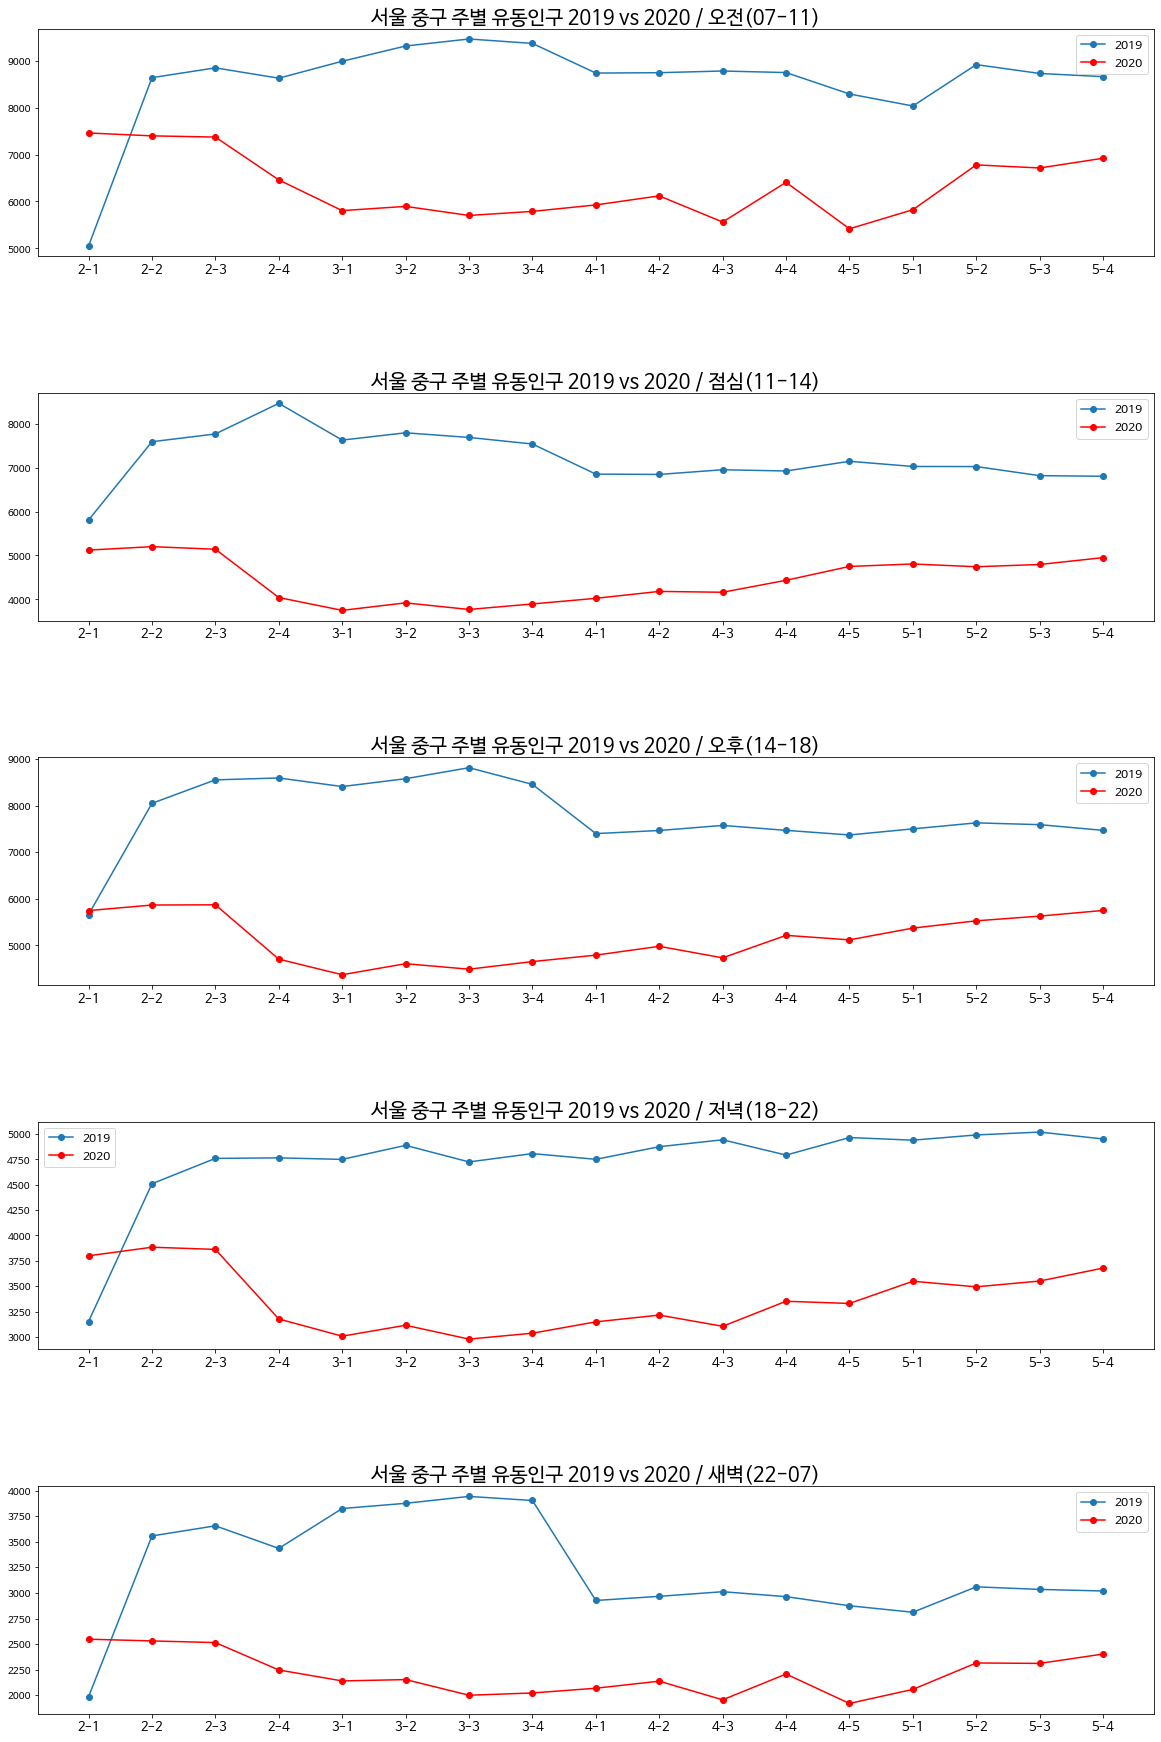

In [ ]:
# 시계열 그래프
# fig = plt.figure(figsize=(18,3))

fig, (ax1, ax2, ax3 , ax4, ax5) = plt.subplots(5,1, figsize=(20,31))
plt.subplots_adjust(hspace = 0.6) # hspace = 0.2

# plt.plot, title()

ax1.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_MORNING_19, linestyle='-', marker='o', label="2019")
ax1.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_MORNING_20, linestyle='-', color='r', marker='o', label="2020")
ax1.set_title('서울 중구 주별 유동인구 2019 vs 2020 / 오전(07-11)', fontsize=20)
ax1.legend(fontsize=12)
ax1.tick_params(axis="x", labelsize=13)

ax2.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_NOON_19, linestyle='-', marker='o', label="2019")
ax2.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_NOON_20, linestyle='-', color='r', marker='o', label="2020")
ax2.set_title('서울 중구 주별 유동인구 2019 vs 2020 / 점심(11-14)', fontsize=20)
ax2.legend(fontsize=12)
ax2.tick_params(axis="x", labelsize=13)

ax3.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_AFTNOON_19, linestyle='-', marker='o', label="2019")
ax3.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_AFTNOON_20, linestyle='-', color='r', marker='o', label="2020")
ax3.set_title('서울 중구 주별 유동인구 2019 vs 2020 / 오후(14-18)', fontsize=20)
ax3.legend(fontsize=12)
ax3.tick_params(axis="x", labelsize=13)

ax4.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_NIGHT_19, linestyle='-', marker='o', label="2019")
ax4.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_NIGHT_20, linestyle='-', color='r', marker='o', label="2020")
ax4.set_title('서울 중구 주별 유동인구 2019 vs 2020 / 저녁(18-22)', fontsize=20)
ax4.legend(fontsize=12)
ax4.tick_params(axis="x", labelsize=13)

ax5.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_DAWN_19, linestyle='-', marker='o', label="2019")
ax5.plot(skt_sj_wm_f.index, skt_sj_wm_f.TMST_DAWN_20, linestyle='-', color='r', marker='o', label="2020")
ax5.set_title('서울 중구 주별 유동인구 2019 vs 2020 / 새벽(22-07)', fontsize=20)
ax5.legend(fontsize=12)
ax5.tick_params(axis="x", labelsize=13)

plt.show()

유동 인구가 매우 감소, 특히 2월 1-2주 전후로 매우 변화, 점심과 새벽 시간대의 2019년과 2020년 차이가 가장 큼, 이는 유흥과 점심 외출이 줄어들었다는 의미로 볼 수 있을 것, 저녁과 오전 시간대는 다른 시간대에 비해 2019년과 2020년 차이가 적은데, 회사를 여전히 가는 경우가 많아서 그럴 수 있음.

### 서울 노원구 주별 유동인구 평균 시계열 그래프 2019 vs 2020


In [ ]:
skt_nw_wm_f = make_data(skt, '서울 노원구')

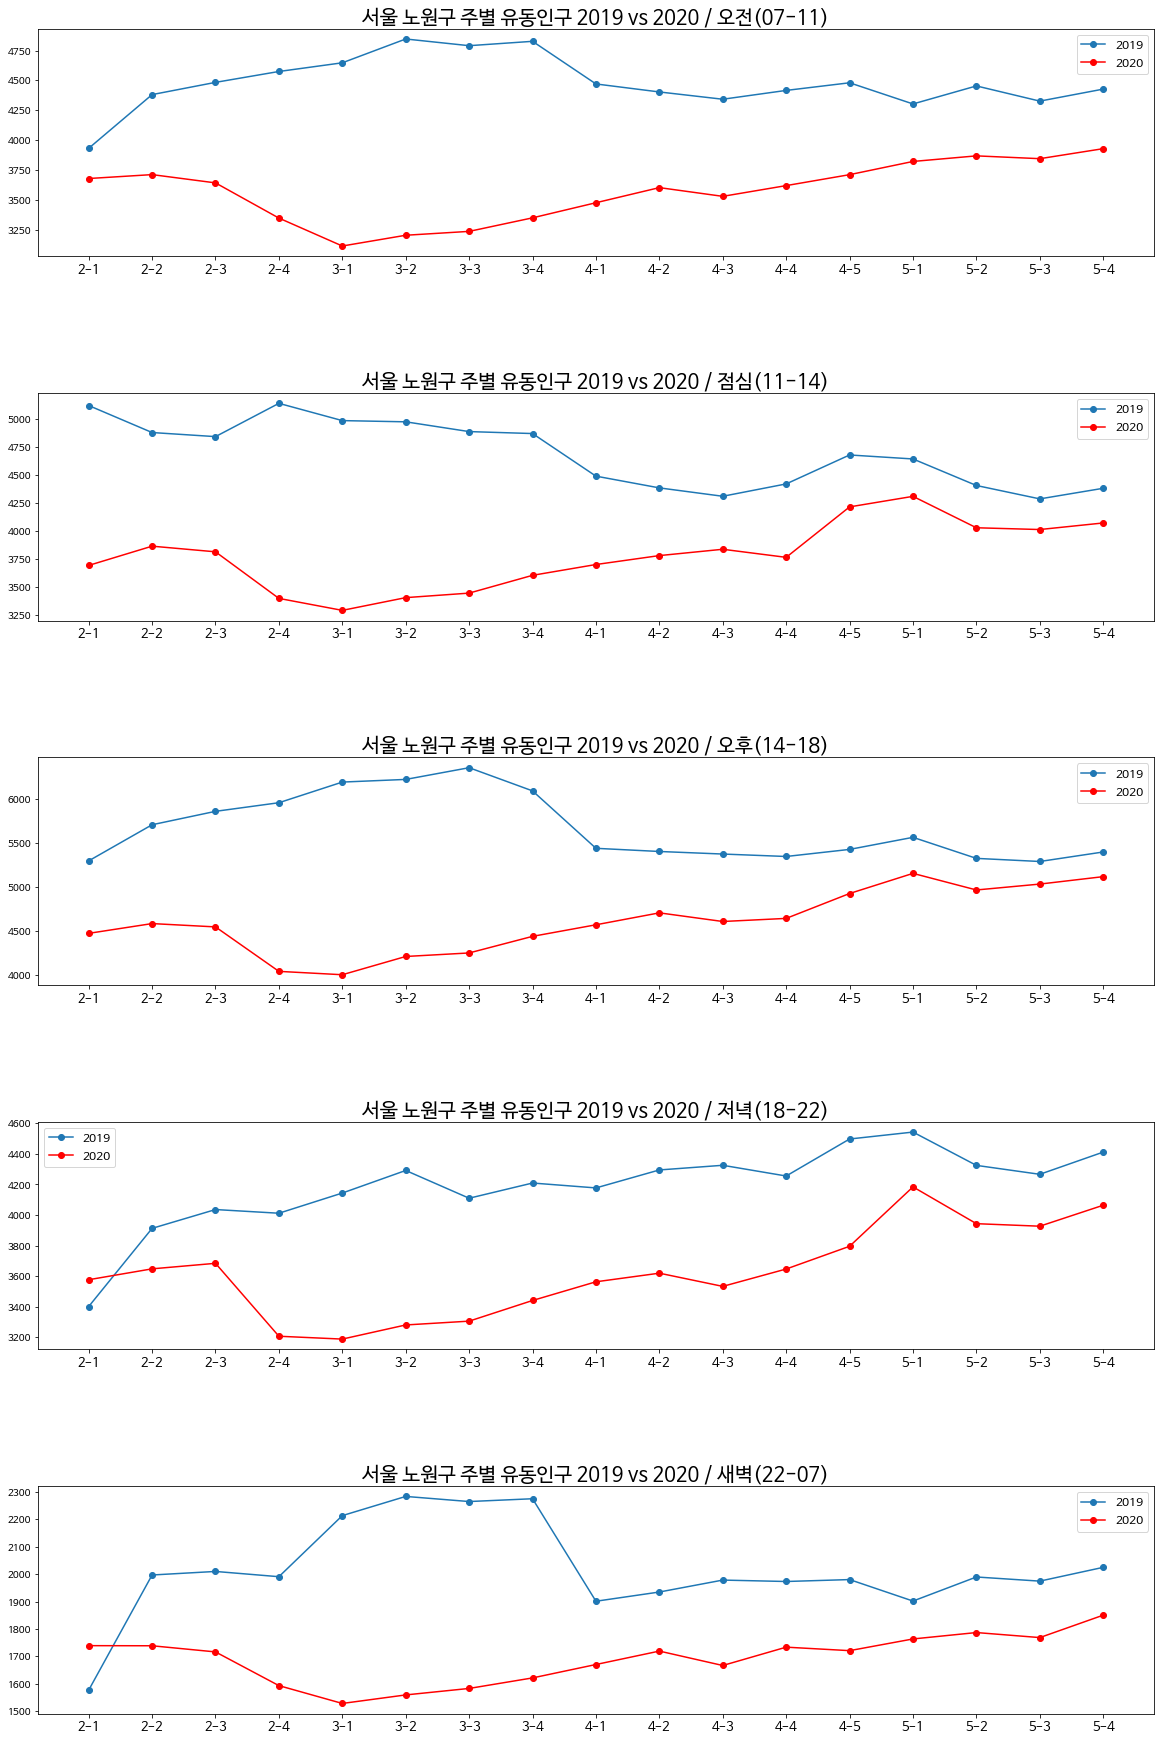

In [ ]:
# 시계열 그래프
# fig = plt.figure(figsize=(18,3))

fig, (ax1, ax2, ax3 , ax4, ax5) = plt.subplots(5,1, figsize=(20,31))
plt.subplots_adjust(hspace = 0.6) # hspace = 0.2

# plt.plot, title()

ax1.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_MORNING_19, linestyle='-', marker='o', label="2019")
ax1.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_MORNING_20, linestyle='-', color='r', marker='o', label="2020")
ax1.set_title('서울 노원구 주별 유동인구 2019 vs 2020 / 오전(07-11)', fontsize=20)
ax1.legend(fontsize=12)
ax1.tick_params(axis="x", labelsize=13)

ax2.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_NOON_19, linestyle='-', marker='o', label="2019")
ax2.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_NOON_20, linestyle='-', color='r', marker='o', label="2020")
ax2.set_title('서울 노원구 주별 유동인구 2019 vs 2020 / 점심(11-14)', fontsize=20)
ax2.legend(fontsize=12)
ax2.tick_params(axis="x", labelsize=13)

ax3.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_AFTNOON_19, linestyle='-', marker='o', label="2019")
ax3.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_AFTNOON_20, linestyle='-', color='r', marker='o', label="2020")
ax3.set_title('서울 노원구 주별 유동인구 2019 vs 2020 / 오후(14-18)', fontsize=20)
ax3.legend(fontsize=12)
ax3.tick_params(axis="x", labelsize=13)

ax4.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_NIGHT_19, linestyle='-', marker='o', label="2019")
ax4.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_NIGHT_20, linestyle='-', color='r', marker='o', label="2020")
ax4.set_title('서울 노원구 주별 유동인구 2019 vs 2020 / 저녁(18-22)', fontsize=20)
ax4.legend(fontsize=12)
ax4.tick_params(axis="x", labelsize=13)

ax5.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_DAWN_19, linestyle='-', marker='o', label="2019")
ax5.plot(skt_nw_wm_f.index, skt_nw_wm_f.TMST_DAWN_20, linestyle='-', color='r', marker='o', label="2020")
ax5.set_title('서울 노원구 주별 유동인구 2019 vs 2020 / 새벽(22-07)', fontsize=20)
ax5.legend(fontsize=12)
ax5.tick_params(axis="x", labelsize=13)

### 대구 중구 주별 유동인구 평균 시계열 그래프 2019 vs 2020

In [ ]:
skt_dj_wm_f = make_data(skt, '대구 중구')

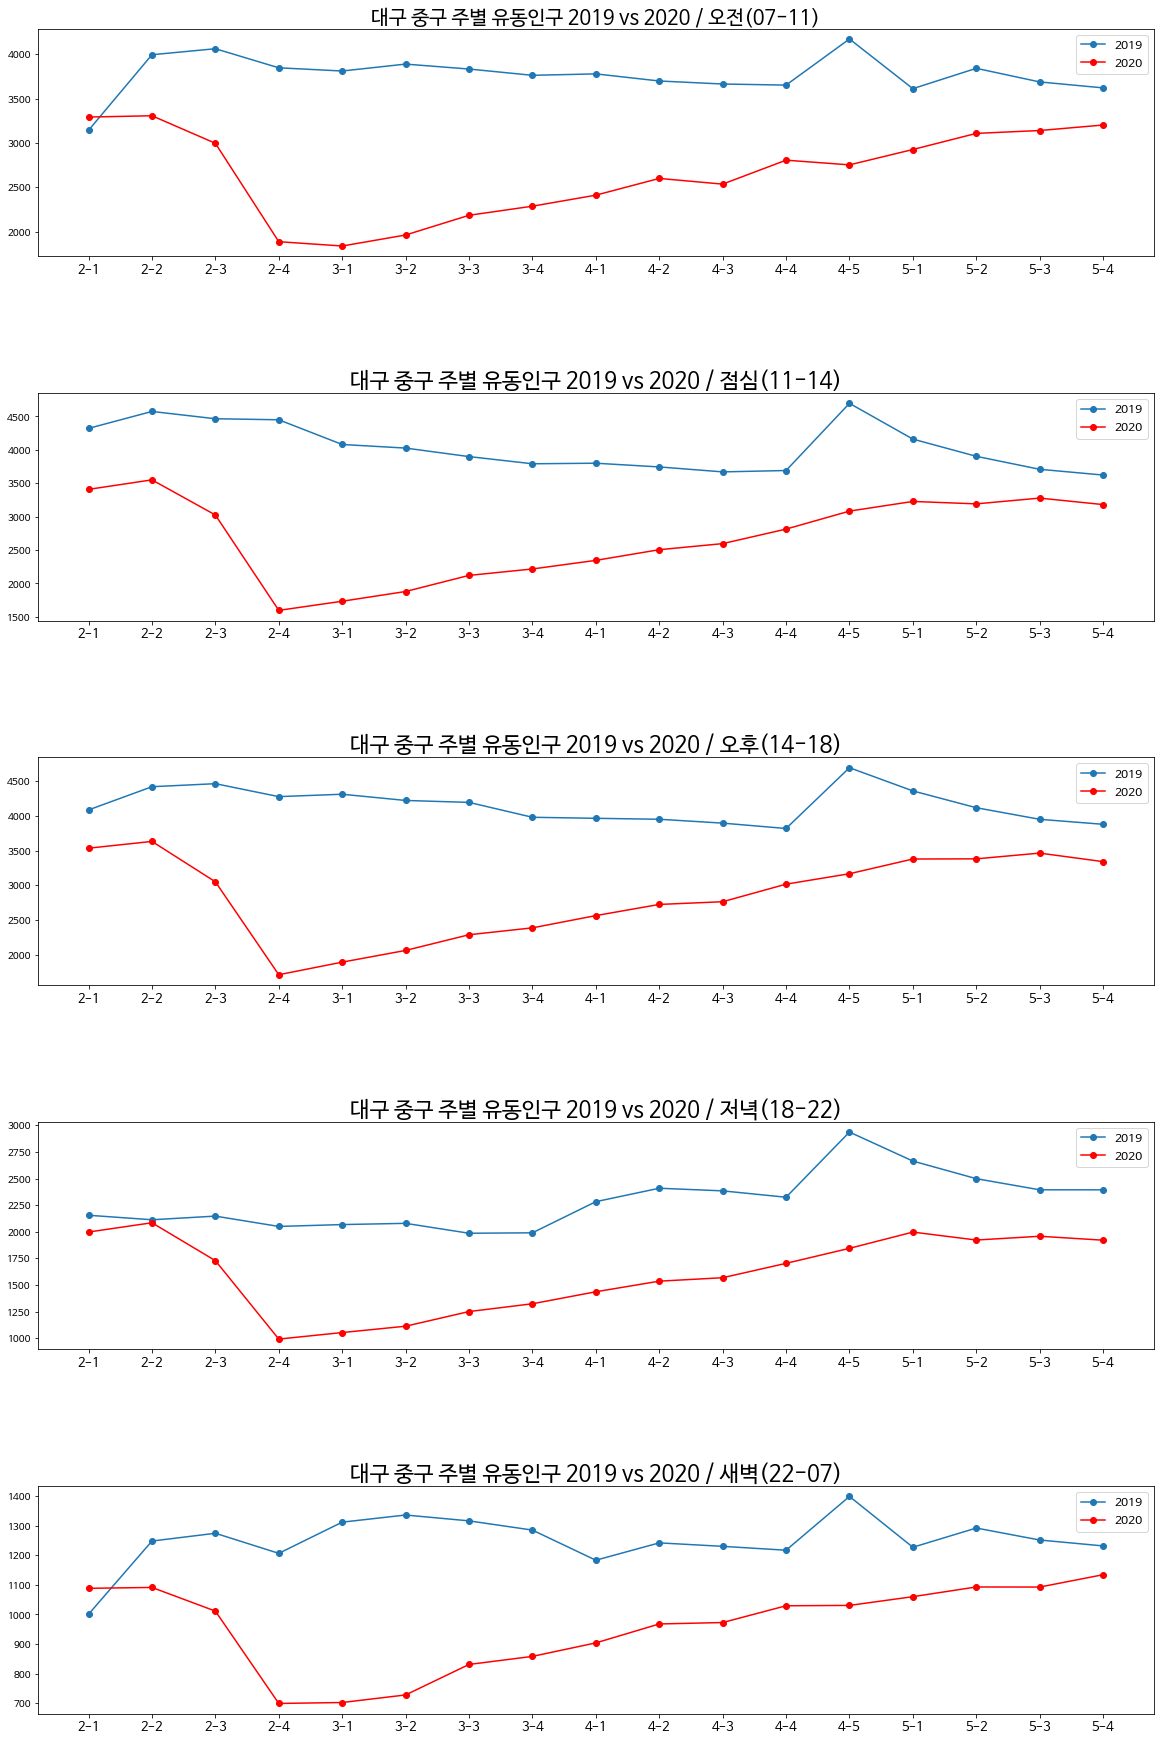

In [ ]:
# 시계열 그래프
# fig = plt.figure(figsize=(18,3))

fig, (ax1, ax2, ax3 , ax4, ax5) = plt.subplots(5,1, figsize=(20,31))
plt.subplots_adjust(hspace = 0.6) # hspace = 0.2

# plt.plot, title()

ax1.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_MORNING_19, linestyle='-', marker='o', label="2019")
ax1.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_MORNING_20, linestyle='-', color='r', marker='o', label="2020")
ax1.set_title('대구 중구 주별 유동인구 2019 vs 2020 / 오전(07-11)', fontsize=20)
ax1.legend(fontsize=12)
ax1.tick_params(axis="x", labelsize=13)

ax2.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_NOON_19, linestyle='-', marker='o', label="2019")
ax2.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_NOON_20, linestyle='-', color='r', marker='o', label="2020")
ax2.set_title('대구 중구 주별 유동인구 2019 vs 2020 / 점심(11-14)', fontsize=22)
ax2.legend(fontsize=12)
ax2.tick_params(axis="x", labelsize=13)

ax3.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_AFTNOON_19, linestyle='-', marker='o', label="2019")
ax3.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_AFTNOON_20, linestyle='-', color='r', marker='o', label="2020")
ax3.set_title('대구 중구 주별 유동인구 2019 vs 2020 / 오후(14-18)', fontsize=22)
ax3.legend(fontsize=12)
ax3.tick_params(axis="x", labelsize=13)

ax4.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_NIGHT_19, linestyle='-', marker='o', label="2019")
ax4.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_NIGHT_20, linestyle='-', color='r', marker='o', label="2020")
ax4.set_title('대구 중구 주별 유동인구 2019 vs 2020 / 저녁(18-22)', fontsize=22)
ax4.legend(fontsize=12)
ax4.tick_params(axis="x", labelsize=13)

ax5.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_DAWN_19, linestyle='-', marker='o', label="2019")
ax5.plot(skt_dj_wm_f.index, skt_dj_wm_f.TMST_DAWN_20, linestyle='-', color='r', marker='o', label="2020")
ax5.set_title('대구 중구 주별 유동인구 2019 vs 2020 / 새벽(22-07)', fontsize=22)
ax5.legend(fontsize=12)
ax5.tick_params(axis="x", labelsize=13)

### 대구 수성구 주별 유동인구 평균 시계열 그래프 2019 vs 2020

In [ ]:
skt_ds_wm_f = make_data(skt, '대구 수성구')

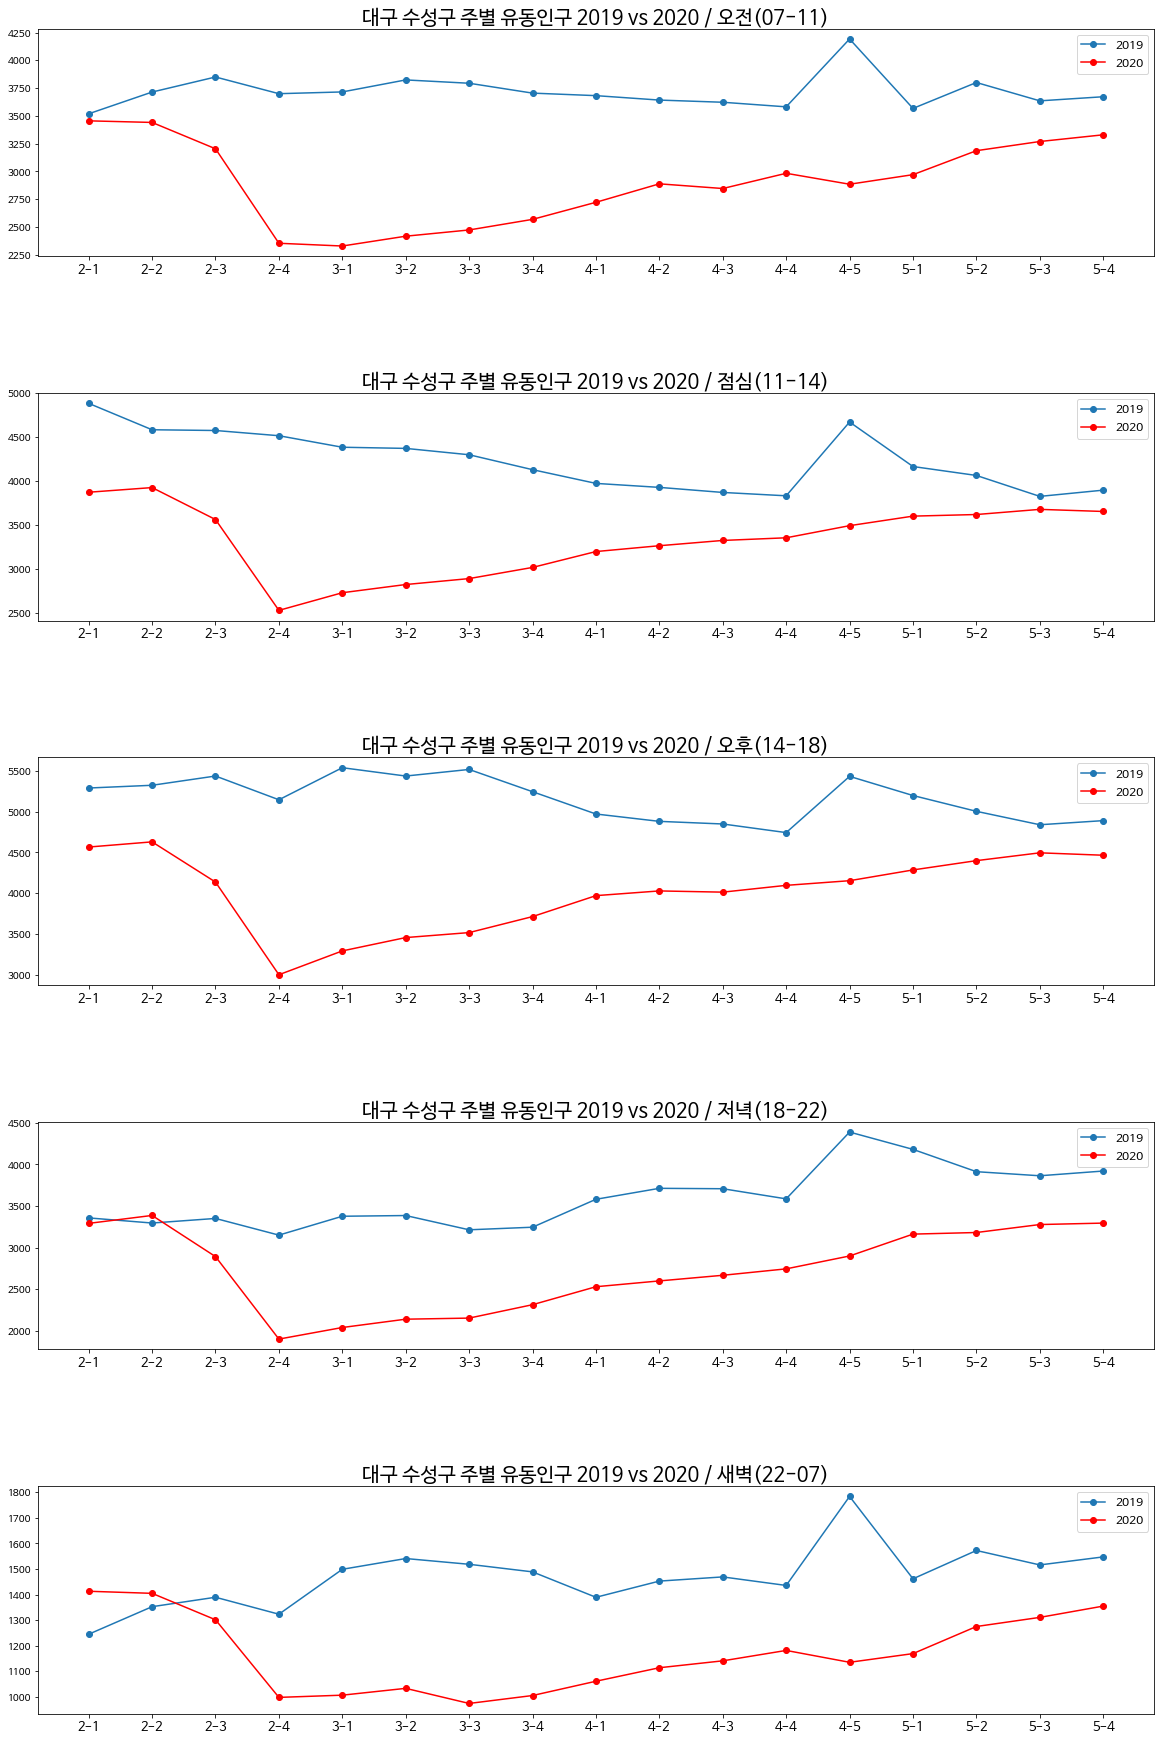

In [ ]:
# 시계열 그래프
# fig = plt.figure(figsize=(18,3))

fig, (ax1, ax2, ax3 , ax4, ax5) = plt.subplots(5,1, figsize=(20,31))
plt.subplots_adjust(hspace = 0.6) # hspace = 0.2

# plt.plot, title()

ax1.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_MORNING_19, linestyle='-', marker='o', label="2019")
ax1.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_MORNING_20, linestyle='-', color='r', marker='o', label="2020")
ax1.set_title('대구 수성구 주별 유동인구 2019 vs 2020 / 오전(07-11)', fontsize=20)
ax1.legend(fontsize=12)
ax1.tick_params(axis="x", labelsize=13)

ax2.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_NOON_19, linestyle='-', marker='o', label="2019")
ax2.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_NOON_20, linestyle='-', color='r', marker='o', label="2020")
ax2.set_title('대구 수성구 주별 유동인구 2019 vs 2020 / 점심(11-14)', fontsize=20)
ax2.legend(fontsize=12)
ax2.tick_params(axis="x", labelsize=13)

ax3.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_AFTNOON_19, linestyle='-', marker='o', label="2019")
ax3.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_AFTNOON_20, linestyle='-', color='r', marker='o', label="2020")
ax3.set_title('대구 수성구 주별 유동인구 2019 vs 2020 / 오후(14-18)', fontsize=20)
ax3.legend(fontsize=12)
ax3.tick_params(axis="x", labelsize=13)

ax4.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_NIGHT_19, linestyle='-',marker='o', label="2019")
ax4.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_NIGHT_20, linestyle='-', color='r', marker='o', label="2020")
ax4.set_title('대구 수성구 주별 유동인구 2019 vs 2020 / 저녁(18-22)', fontsize=20)
ax4.legend(fontsize=12)
ax4.tick_params(axis="x", labelsize=13)

ax5.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_DAWN_19, linestyle='-', marker='o', label="2019")
ax5.plot(skt_ds_wm_f.index, skt_ds_wm_f.TMST_DAWN_20, linestyle='-', color='r', marker='o', label="2020")
ax5.set_title('대구 수성구 주별 유동인구 2019 vs 2020 / 새벽(22-07)', fontsize=20)
ax5.legend(fontsize=12)
ax5.tick_params(axis="x", labelsize=13)

서울과 대구 다른 양상 나타남, 대구는 신천지가 터진 02.18 기준으로 유동 인구 수가 확 줄어듬, 서울은 이미 줄은 상태 (서울에서 확진자가 조금씩 나오던 때), 대부분 정상화 되어가는, 올라가는 추세인데, 중구는 아직 줄어든 채 그대로 유지 (특히 저녁 시간대)

# **3. SK AGE 제공 데이터 EDA**

시각화 아이디어

- 연령별 유동 인구 차이 2019 vs 2020
(모든 나이대 보고 줄어드는 나이대, 그리 줄지 않는 나이대 나눠서 보기)
- 성별 유동 인구 차이 2019 vs 2020

In [ ]:
# 구 정보 추가
temp = ska['HDONG_CD'].astype(str).str.slice(start=0, stop=5)
temp = temp.apply(lambda x: '서울 중구' if x == "11140" else x)
temp = temp.apply(lambda x: '서울 노원구' if x == "11350" else x)
temp = temp.apply(lambda x: '대구 중구' if x == "27110" else x)
temp = temp.apply(lambda x: '대구 수성구' if x == "27260" else x)
ska['HGU_NM'] = temp

In [ ]:
ska = ska[['STD_YMD', 'STD_YM', 'HGU_NM', 'HDONG_CD', 'HDONG_NM', 'MAN_FLOW_POP_CNT_0004', 'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014','MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024','MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034','MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
       'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
       'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
       'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
       'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
       'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
       'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
       'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
       'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
       'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
       'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
       'WMAN_FLOW_POP_CNT_70U']]
ska_backup1 = ska.copy()

In [ ]:
# 시간대 나누기

# 7-11 아침(TMST_MON) / 11-14 점심 / 14-18 오후 / 18-22 저녁 / 22-7 심야
ska['MAN_CNT_00'] = np.sum(ska.iloc[:,5:7], axis=1) # < 10
ska['MAN_CNT_10'] = np.sum(ska.iloc[:,7:9], axis=1) # 10대
ska['MAN_CNT_20'] = np.sum(ska.iloc[:,9:11], axis=1) # 20대
ska['MAN_CNT_30'] = np.sum(ska.iloc[:,11:13], axis=1) # 30대
ska['MAN_CNT_40'] = np.sum(ska.iloc[:,13:15], axis=1) # 40대
ska['MAN_CNT_50'] = np.sum(ska.iloc[:,15:17], axis=1) # 50대
ska['MAN_CNT_60'] = np.sum(ska.iloc[:,17:19], axis=1) # 60대
ska['MAN_CNT_70U'] = np.sum(ska.iloc[:,19:20], axis=1) # > 70

ska['WMAN_CNT_00'] = np.sum(ska.iloc[:,20:22], axis=1) # < 10
ska['WMAN_CNT_10'] = np.sum(ska.iloc[:,22:24], axis=1) # 10대
ska['WMAN_CNT_20'] = np.sum(ska.iloc[:,24:26], axis=1) # 20대
ska['WMAN_CNT_30'] = np.sum(ska.iloc[:,26:28], axis=1) # 30대
ska['WMAN_CNT_40'] = np.sum(ska.iloc[:,28:30], axis=1) # 40대
ska['WMAN_CNT_50'] = np.sum(ska.iloc[:,30:32], axis=1) # 50대
ska['WMAN_CNT_60'] = np.sum(ska.iloc[:,32:34], axis=1) # 60대
ska['WMAN_CNT_70U'] = np.sum(ska.iloc[:,34:35], axis=1) # > 70

ska = ska[['STD_YMD', 'HGU_NM', 'HDONG_NM', 'MAN_CNT_00', 'MAN_CNT_10', 'MAN_CNT_20', 'MAN_CNT_30', 'MAN_CNT_40', 'MAN_CNT_50', 'MAN_CNT_60', 'MAN_CNT_70U', 'WMAN_CNT_00', 'WMAN_CNT_10', 'WMAN_CNT_20', 'WMAN_CNT_30', 'WMAN_CNT_40', 'WMAN_CNT_50', 'WMAN_CNT_60', 'WMAN_CNT_70U']]
ska_backup2 = ska.copy()

### 연령별 유동인구 시계열

In [ ]:
ska_g = ska.resample('D').mean() # 클러스터링 하고 여기가 바껴야 함
ska_g = ska_g.iloc[1:484]
ska_g = ska_g.resample('W-Fri').mean()

ska_g = ska_g.iloc[52:,].reset_index() # NA 행 지우고 연도별로 추출해야 일반화시켜야 쓰기 편할듯
ska_g.columns = ['STD_YMD_20', 'MAN_CNT_00_20', 'MAN_CNT_10_20', 'MAN_CNT_20_20', 'MAN_CNT_30_20', 'MAN_CNT_40_20', 'MAN_CNT_50_20', 'MAN_CNT_60_20', 'MAN_CNT_70U_20', 'WMN_CNT_00_20', 'WMN_CNT_10_20', 'WMN_CNT_20_20', 'WMN_CNT_30_20', 'WMN_CNT_40_20', 'WMN_CNT_50_20', 'WMN_CNT_60_20', 'WMN_CNT_70U_20']
ska_g.drop(['STD_YMD_20'], axis=1,inplace=True)
ska_g.index = ['2-1', '2-2', '2-3', '2-4', '3-1', '3-2', '3-3', '3-4', '4-1', '4-2', '4-3', '4-4','4-5','5-1', '5-2', '5-3', '5-4']

In [ ]:
ska_g['10대'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_10_20'],ska_g.loc[:,'WMN_CNT_10_20']],axis=1), axis=1)
ska_g['20대'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_20_20'],ska_g.loc[:,'WMN_CNT_20_20']],axis=1), axis=1)
ska_g['30대'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_30_20'],ska_g.loc[:,'WMN_CNT_30_20']],axis=1), axis=1)
ska_g['40대'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_40_20'],ska_g.loc[:,'WMN_CNT_40_20']],axis=1), axis=1)
ska_g['50대'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_50_20'],ska_g.loc[:,'WMN_CNT_50_20']],axis=1), axis=1)
ska_g['60대 이상'] = np.sum(pd.concat([ska_g.loc[:,'MAN_CNT_60_20'],ska_g.loc[:,'MAN_CNT_70U_20'],ska_g.loc[:,'WMN_CNT_60_20'],ska_g.loc[:,'MAN_CNT_70U_20']],axis=1), axis=1)

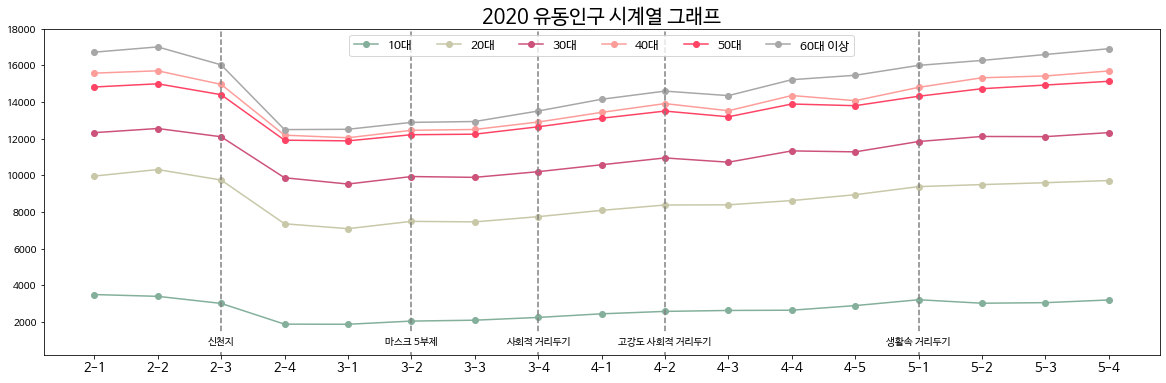

In [ ]:
fig = plt.figure(figsize=(20,6))

plt.plot(ska_g.index, ska_g['10대'], linestyle='-', marker='o', color='#83AF9B', label="10대")
plt.plot(ska_g.index, ska_g['20대'], linestyle='-', marker='o', color='#C8C8A9',label="20대")
plt.plot(ska_g.index, ska_g['30대'], linestyle='-', marker='o', color='#CC527A',label="30대")
plt.plot(ska_g.index, ska_g['40대'], linestyle='-', marker='o',color = '#FC9D9A', label="40대")
plt.plot(ska_g.index, ska_g['50대'], linestyle='-', marker='o',color='#FE4365',label="50대")
plt.plot(ska_g.index, ska_g['60대 이상'], linestyle='-', marker='o',color='#A8A7A7',label="60대 이상")

mycolor ='grey'; min=900
plt.axvline(x='2-3',color=mycolor,linestyle='--')
plt.text('2-3',min,'신천지', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='3-2',color=mycolor,linestyle='--')
plt.text('3-2',min, '마스크 5부제', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='3-4', color=mycolor,linestyle='--')
plt.text('3-4',min, '사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='4-2', color=mycolor,linestyle='--')
plt.text('4-2', min, '고강도 사회적 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')
plt.axvline(x='5-1', color=mycolor,linestyle='--')
plt.text('5-1',min,'생활속 거리두기', ha='center', va='center',rotation='horizontal', backgroundcolor='white')

plt.legend(loc='upper center', prop={'size': 12}, ncol=6)
plt.title('2020 유동인구 시계열 그래프', size=20)
plt.ylim(200, 18000)
plt.tick_params(axis="x", labelsize=13)

### 서울 중구 연령별 유동인구 시계열

In [ ]:
# 데이터 만들기
def make_data2(data, GU_NM):
    data_g = data[data.HGU_NM == GU_NM]
    data_g = data_g.resample('D').mean() # 클러스터링 하고 여기가 바껴야 함
    data_g = data_g.iloc[1:484]
    data_g = data_g.resample('W-Fri').mean()

    data_g_f = pd.concat([data_g.iloc[:17,].reset_index(), data_g.iloc[52:,].reset_index()], axis=1) # NA 행 지우고 연도별로 추출해야 일반화시켜야 쓰기 편할듯
    data_g_f.columns = ['STD_YMD_19', 'MAN_CNT_00_19', 'MAN_CNT_10_19', 'MAN_CNT_20_19', 'MAN_CNT_30_19', 'MAN_CNT_40_19', 'MAN_CNT_50_19', 'MAN_CNT_60_19', 'MAN_CNT_70U_19', 'WMN_CNT_00_19', 'WMN_CNT_10_19', 'WMN_CNT_20_19', 'WMN_CNT_30_19', 'WMN_CNT_40_19', 'WMN_CNT_50_19', 'WMN_CNT_60_19', 'WMN_CNT_70U_19', 
                           'STD_YMD_20', 'MAN_CNT_00_20', 'MAN_CNT_10_20', 'MAN_CNT_20_20', 'MAN_CNT_30_20', 'MAN_CNT_40_20', 'MAN_CNT_50_20', 'MAN_CNT_60_20', 'MAN_CNT_70U_20', 'WMN_CNT_00_20', 'WMN_CNT_10_20', 'WMN_CNT_20_20', 'WMN_CNT_30_20', 'WMN_CNT_40_20', 'WMN_CNT_50_20', 'WMN_CNT_60_20', 'WMN_CNT_70U_20']
    data_g_f.drop(['STD_YMD_19', 'STD_YMD_20'], axis=1,inplace=True)
    data_g_f.index = ['2-1', '2-2', '2-3', '2-4', '3-1', '3-2', '3-3', '3-4', '4-1', '4-2', '4-3', '4-4','4-5','5-1', '5-2', '5-3', '5-4']

    return data_g_f

In [ ]:
ska_sj_ws_f = make_data2(ska, '서울 중구')

ska_sj_ws_fw = ska_sj_ws_f.filter(like="WMN")
ska_sj_ws_fm = ska_sj_ws_f.filter(like="MAN")

(0.0, 15000.0)

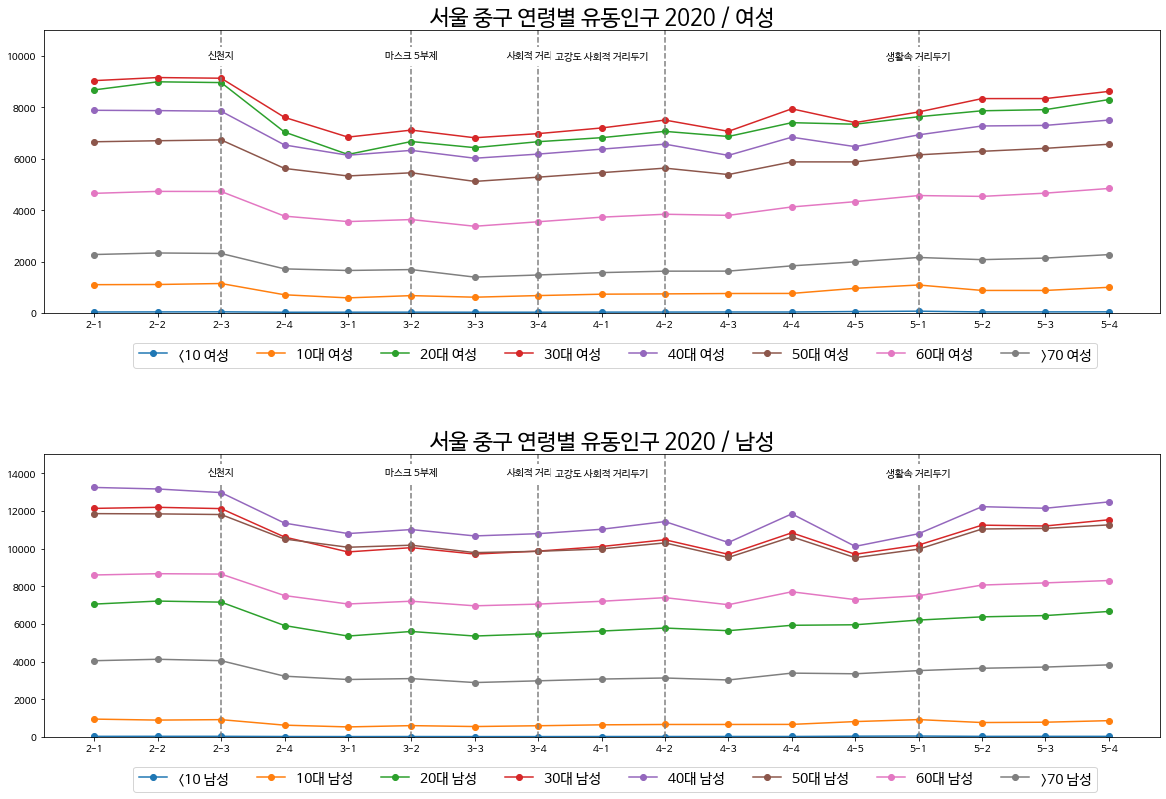

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,13))
plt.subplots_adjust(hspace = 0.5) # hspace = 0.2

ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_00_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_10_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_20_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_40_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_60_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_70U_20, linestyle='-', marker='o', label="value")

issue_line(ax1, 10000, 'grey')

ax1.legend(['<10 여성', '10대 여성', '20대 여성', '30대 여성', '40대 여성', '50대 여성', '60대 여성', '>70 여성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax1.set_title('서울 중구 연령별 유동인구 2020 / 여성', fontsize=22)

plt.sca(ax1)
plt.ylim(0, 11000)

ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_00_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_10_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_20_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_60_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_70U_20, linestyle='-', marker='o', label="value")

issue_line(ax2, 14000, 'grey')

ax2.legend(['<10 남성', '10대 남성', '20대 남성', '30대 남성', '40대 남성', '50대 남성', '60대 남성', '>70 남성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax2.set_title('서울 중구 연령별 유동인구 2020 / 남성', fontsize=22)

plt.sca(ax2)
plt.ylim(0, 15000)

밑에 세 선이 바로 10세 미만, 10대 70대 이상,
<br>
위의 20-60대는 2월 18일 이후로 급격히 활동이 줄어드는 추세를 보이다가 3월부터 4월에는 안정적으로 줄어들었다. 그리고 5월 이후 다시 늘어나는 양상
<br>
남성과 여성의 그래프 모양에 큰 차이는 없으나, 20대는 상대적으로 여성 유동 인구가 조금 더 많고, 주로 직장생활을 하는 30-50대의 유동 인구는 남성이 훨씬 많다. 

## 서울 노원구 연령별 유동인구 시계열

In [ ]:
ska_nw_ws_f = make_data2(ska, '서울 노원구')

ska_nw_ws_fw = ska_nw_ws_f.filter(like="WMN")
ska_nw_ws_fm = ska_nw_ws_f.filter(like="MAN")

(0.0, 12048.674962406018)

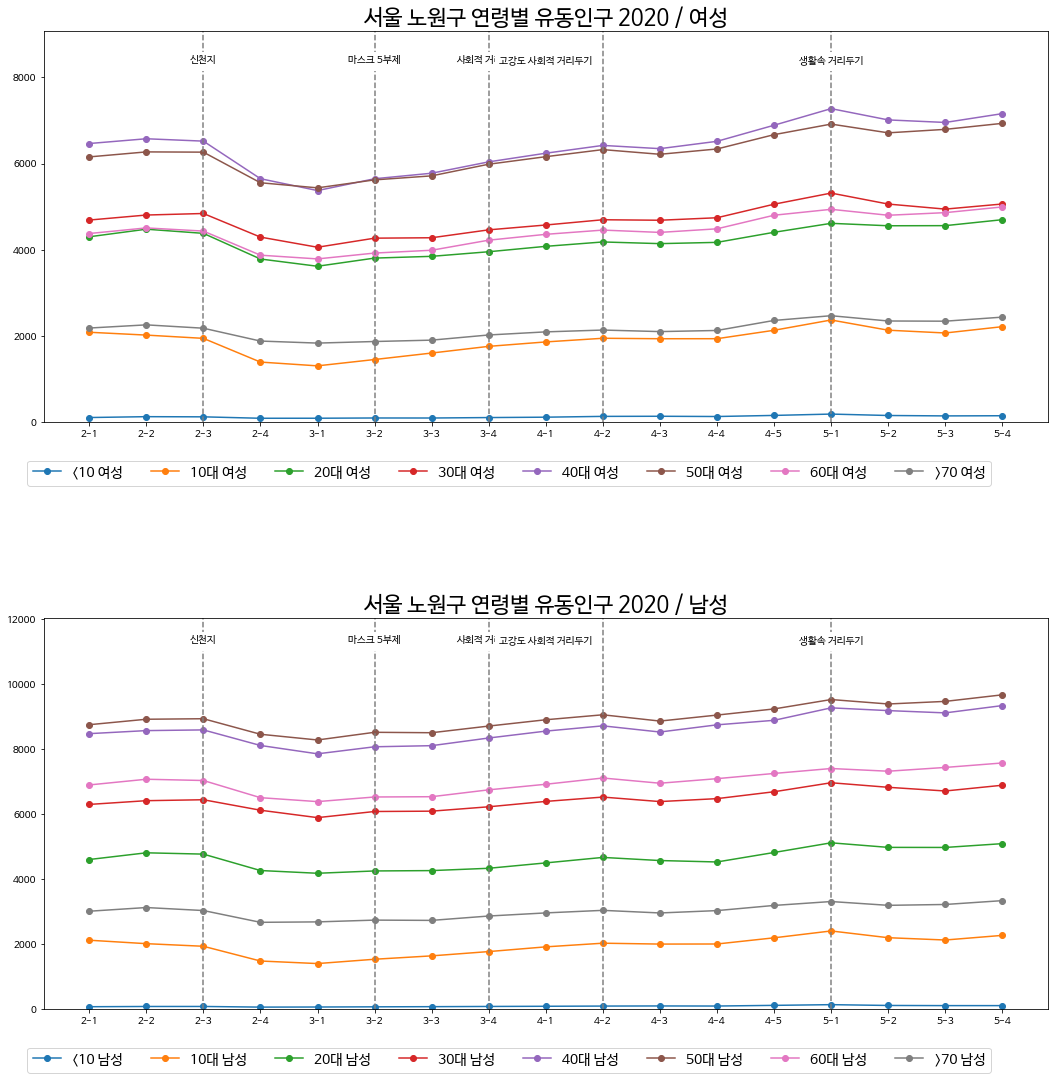

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,18))
plt.subplots_adjust(hspace = 0.5) # hspace = 0.2

ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_00_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_10_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_20_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_40_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_60_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_70U_20, linestyle='-', marker='o', label="value")

max = ska_nw_ws_fw.values.max()
issue_line(ax1, max, 'grey')

ax1.legend(['<10 여성', '10대 여성', '20대 여성', '30대 여성', '40대 여성', '50대 여성', '60대 여성', '>70 여성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax1.set_title('서울 노원구 연령별 유동인구 2020 / 여성', fontsize=22)

plt.sca(ax1)
plt.ylim(0, max+700)

ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_00_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_10_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_20_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_60_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_70U_20, linestyle='-', marker='o', label="value")

max = ska_nw_ws_fm.values.max()
issue_line(ax2, max, 'grey')

ax2.legend(['<10 남성', '10대 남성', '20대 남성', '30대 남성', '40대 남성', '50대 남성', '60대 남성', '>70 남성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax2.set_title('서울 노원구 연령별 유동인구 2020 / 남성', fontsize=22)

plt.sca(ax2)
plt.ylim(0, max+700)

중구에 비해 크게 유동인구가 엄청 들쭉날쭉하진 않음(이유는 주거 단지 위주이므로 주변 식재료를 사러 가는 등 의식주와 관련된 불가피한 생활 속 이동은 계속되었음으로 생각됨), 중구에 비해 40-50대 유동인구가 가장 많고 다음으로 30대와 60대, 그 다음으로 20대 형태이다.

## 대구 중구 연령별 유동인구 시계열

In [ ]:
ska_dj_ws_f = make_data2(ska, '서울 노원구')

ska_dj_ws_fw = ska_dj_ws_f.filter(like="WMN")
ska_dj_ws_fm = ska_dj_ws_f.filter(like="MAN")

(0.0, 10180.89691729324)

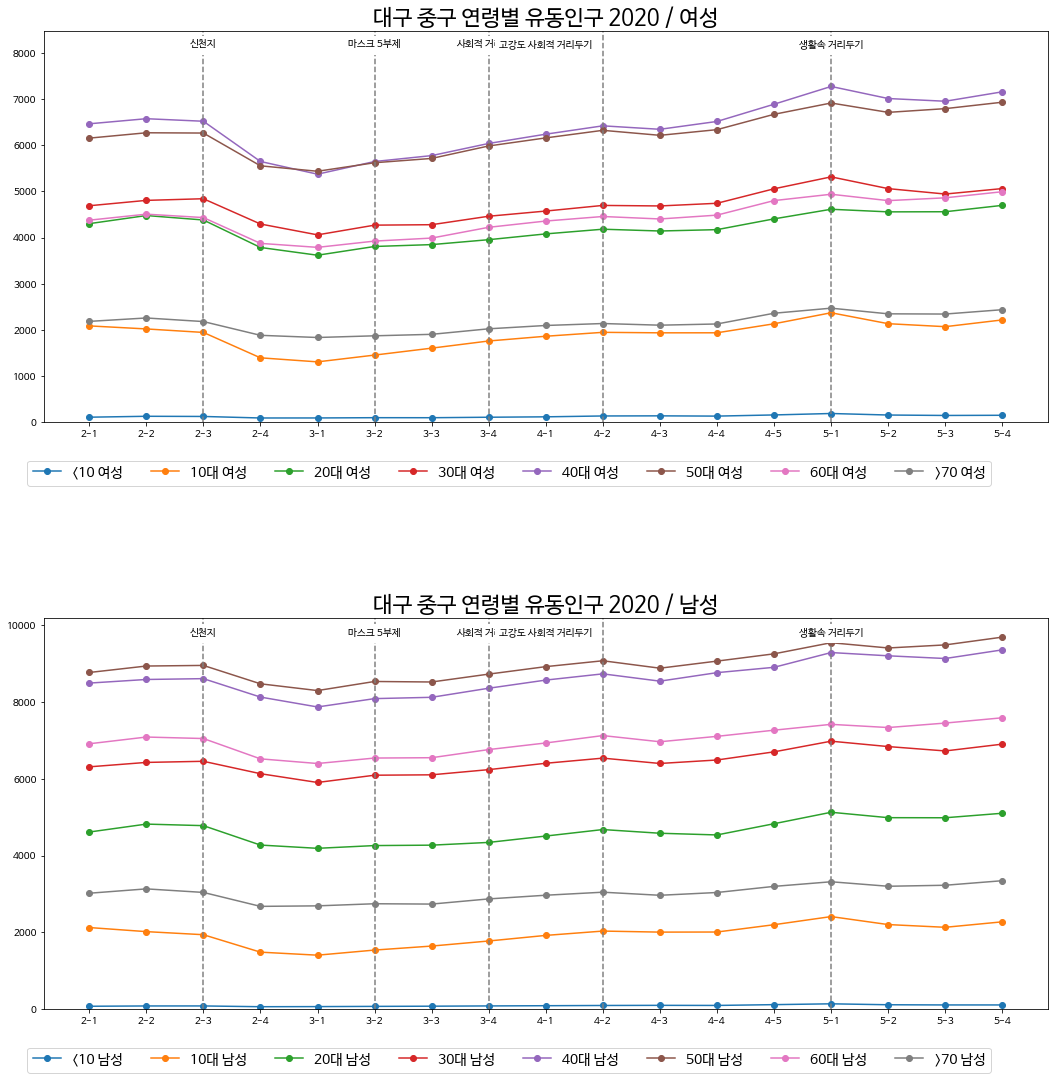

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,18))
plt.subplots_adjust(hspace = 0.5) # hspace = 0.2

ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_00_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_10_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_20_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_40_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_60_20, linestyle='-', marker='o', label="value")
ax1.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_70U_20, linestyle='-', marker='o', label="value")

max = ska_dj_ws_fw.values.max()
issue_line(ax1, max-200, 'grey')

ax1.legend(['<10 여성', '10대 여성', '20대 여성', '30대 여성', '40대 여성', '50대 여성', '60대 여성', '>70 여성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax1.set_title('대구 중구 연령별 유동인구 2020 / 여성', fontsize=22)

plt.sca(ax1)
plt.ylim(0, max+100)

ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_00_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_10_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_20_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_60_20, linestyle='-', marker='o', label="value")
ax2.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_70U_20, linestyle='-', marker='o', label="value")

max = ska_dj_ws_fw.values.max()
issue_line(ax2, max+1400, 'grey')

ax2.legend(['<10 남성', '10대 남성', '20대 남성', '30대 남성', '40대 남성', '50대 남성', '60대 남성', '>70 남성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax2.set_title('대구 중구 연령별 유동인구 2020 / 남성', fontsize=22)

plt.sca(ax2)
plt.ylim(0, max+1800)

연령대와 무관하게 신천지 이후로 유동인구 확 줄어들음, 굉장히! 그러나 그 이후로는 계속 수도권 위주 감염, 유동인구가 점진적으로 증가 중임을 확인 가능


## 대구 수성구 연령별 유동인구 시계열

In [ ]:
ska_ds_ws_f = make_data2(ska, '대구 수성구')

ska_ds_ws_fw = ska_ds_ws_f.filter(like="WMN")
ska_ds_ws_fm = ska_ds_ws_f.filter(like="MAN")

(0.0, 10500.056273291939)

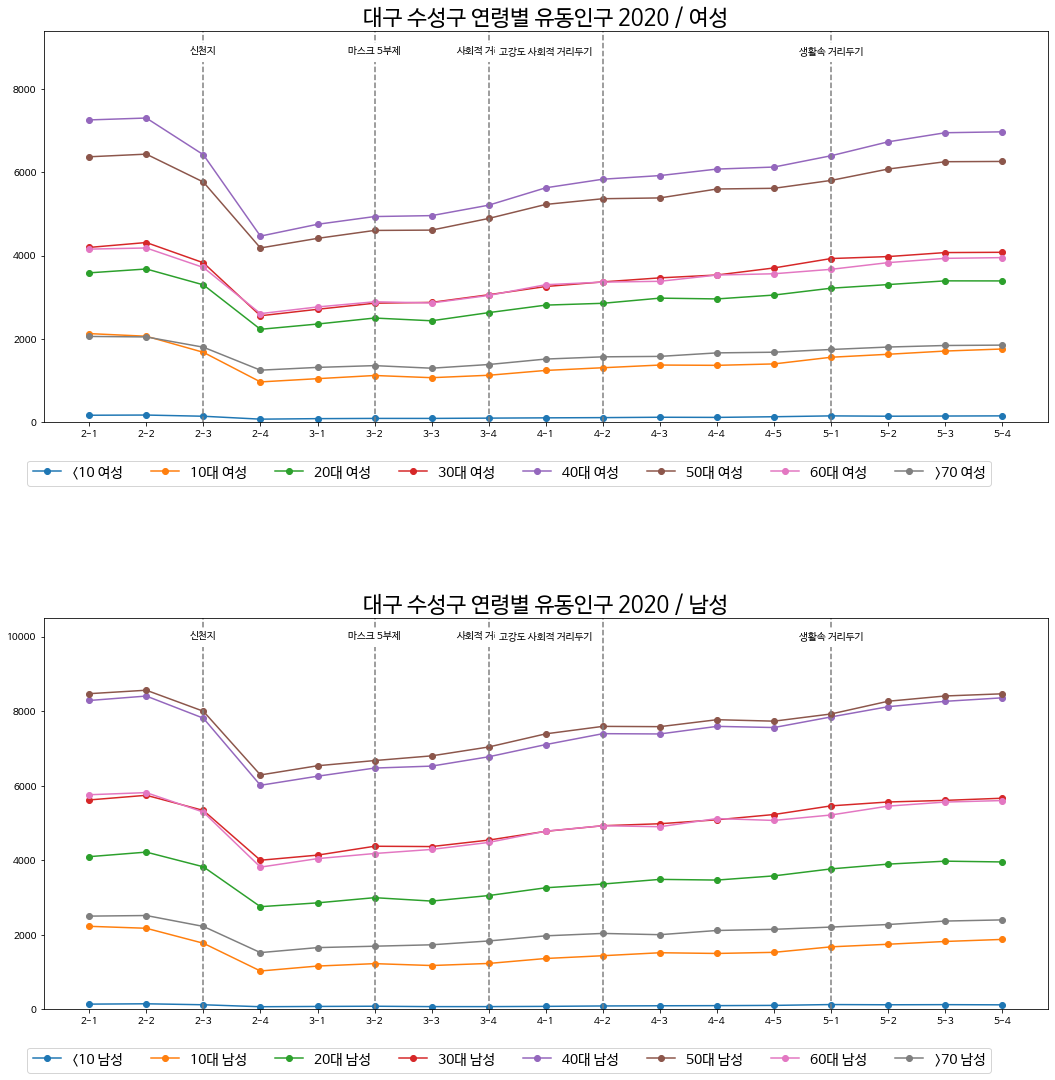

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,18))
plt.subplots_adjust(hspace = 0.5) # hspace = 0.2

ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_00_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_10_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_20_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_40_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_60_20, linestyle='-', marker='o')
ax1.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_70U_20, linestyle='-', marker='o')

max = ska_ds_ws_fw.values.max()
issue_line(ax1, max-500, 'grey')

ax1.legend(['<10 여성', '10대 여성', '20대 여성', '30대 여성', '40대 여성', '50대 여성', '60대 여성', '>70 여성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax1.set_title('대구 수성구 연령별 유동인구 2020 / 여성', fontsize=22)

plt.sca(ax1)
plt.ylim(0, max)

ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_00_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_10_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_20_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_60_20, linestyle='-', marker='o')
ax2.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_70U_20, linestyle='-', marker='o')

ax2.legend(['<10 남성', '10대 남성', '20대 남성', '30대 남성', '40대 남성', '50대 남성', '60대 남성', '>70 남성'], loc='best', prop={'size': 14}, bbox_to_anchor=(0.95, -0.08), ncol=8)
ax2.set_title('대구 수성구 연령별 유동인구 2020 / 남성', fontsize=22)

max = ska_ds_ws_fm.values.max()
issue_line(ax2, max, 'grey')

plt.sca(ax2)
plt.ylim(0, max+500)

유흥가가 있는 중구와 비교했을 때 교육열이 높은 수성구의 경우 마찬가지로 신천지 터진 이후 유동인구가 줄었으나 중구만큼의 폭은 아니다. 그리고 마찬가지로 점진적인 꾸준한 증가추세가 나타난다.

## 업무지구 vs 주거지구

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

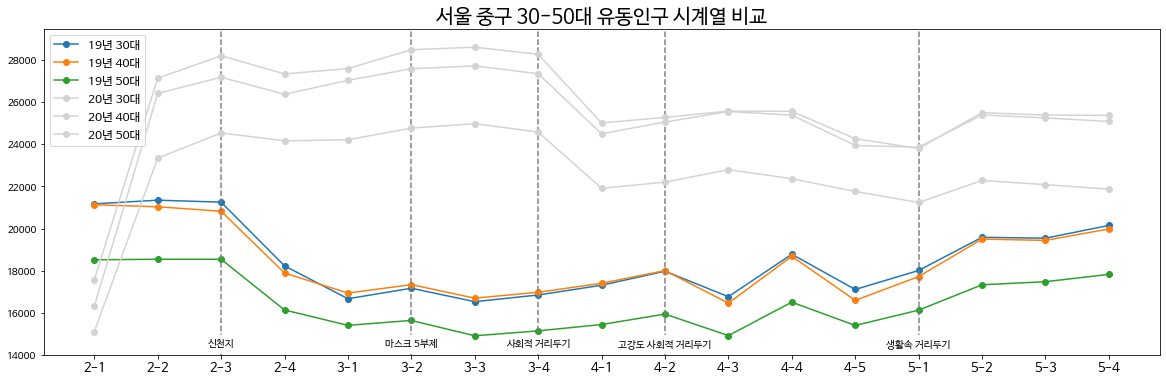

In [ ]:
fig = plt.figure(figsize=(20,6))

plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_30_20, ska_sj_ws_fw.WMN_CNT_30_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 30대")
plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_40_20, ska_sj_ws_fw.WMN_CNT_40_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 40대")
plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_50_20, ska_sj_ws_fw.WMN_CNT_50_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 50대")

issue_line2(14500, 'grey')

plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_30_19, ska_sj_ws_fw.WMN_CNT_30_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 30대")
plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_40_19, ska_sj_ws_fw.WMN_CNT_40_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 40대")
plt.plot(ska_sj_ws_fm.index, np.sum(pd.concat([ska_sj_ws_fm.MAN_CNT_50_19, ska_sj_ws_fw.WMN_CNT_50_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 50대")

plt.legend(loc='best', prop={'size': 12})
plt.title('서울 중구 30-50대 유동인구 시계열 비교', size=20)
plt.ylim(14000, 29500)
plt.xticks(fontsize=13)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

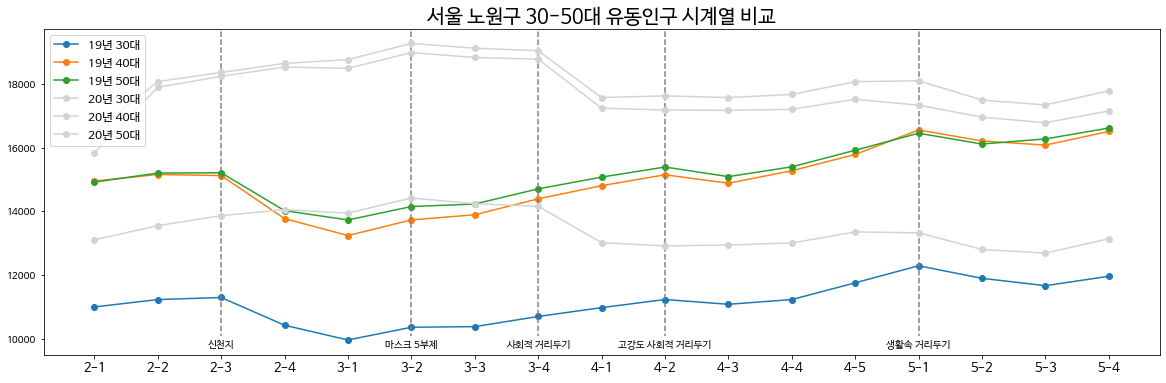

In [ ]:
fig = plt.figure(figsize=(20,6))

plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_30_20, ska_nw_ws_fw.WMN_CNT_30_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 30대")
plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_40_20, ska_nw_ws_fw.WMN_CNT_40_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 40대")
plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_50_20, ska_nw_ws_fw.WMN_CNT_50_20], axis=1), axis=1), linestyle='-', marker='o', label="19년 50대")

issue_line2(9800, 'grey')

plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_30_19, ska_nw_ws_fw.WMN_CNT_30_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 30대")
plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_40_19, ska_nw_ws_fw.WMN_CNT_40_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 40대")
plt.plot(ska_nw_ws_fw.index, np.sum(pd.concat([ska_nw_ws_fm.MAN_CNT_50_19, ska_nw_ws_fw.WMN_CNT_50_19], axis=1), axis=1), linestyle='-', marker='o', color='lightgrey', label="20년 50대")

plt.legend(loc='best', prop={'size': 12})
plt.title('서울 노원구 30-50대 유동인구 시계열 비교', size=20)
plt.xticks(fontsize=13)

## 타임라인 추가한 테마별 시계열 (2019년도 포함)

- 직장인들이 많은 중구, 30-50대 남성의 추이 확인

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

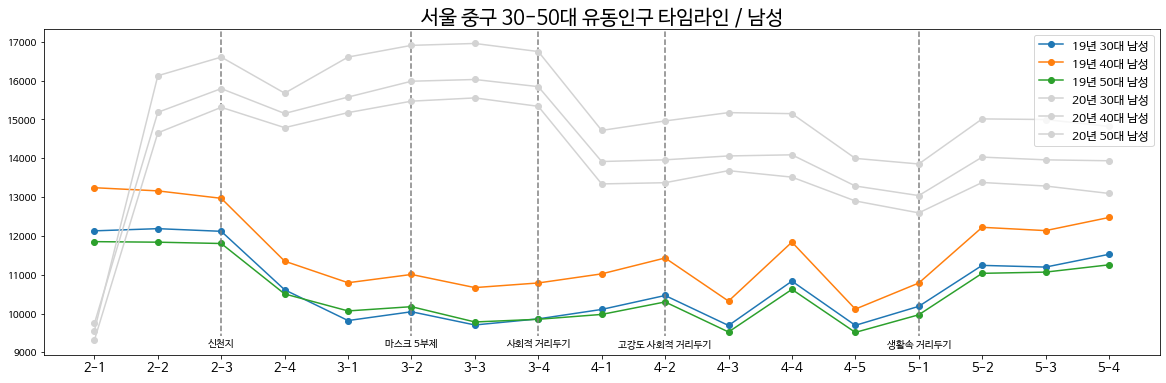

In [ ]:
fig = plt.figure(figsize=(20,6))

plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="19년 30대 남성")
plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', label="19년 40대 남성")
plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', label="19년 50대 남성")

issue_line2(9200, 'grey')

plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="20년 30대 남성")
plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="20년 40대 남성")
plt.plot(ska_sj_ws_fm.index, ska_sj_ws_fm.MAN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="20년 50대 남성")

# plt.legend(['30대 남성', '40대 남성', '50대 남성'], loc='best', prop={'size': 14})
plt.legend(loc='best', prop={'size': 12})
plt.title('서울 중구 30-50대 유동인구 타임라인 / 남성', size=20)
plt.xticks(fontsize=13)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

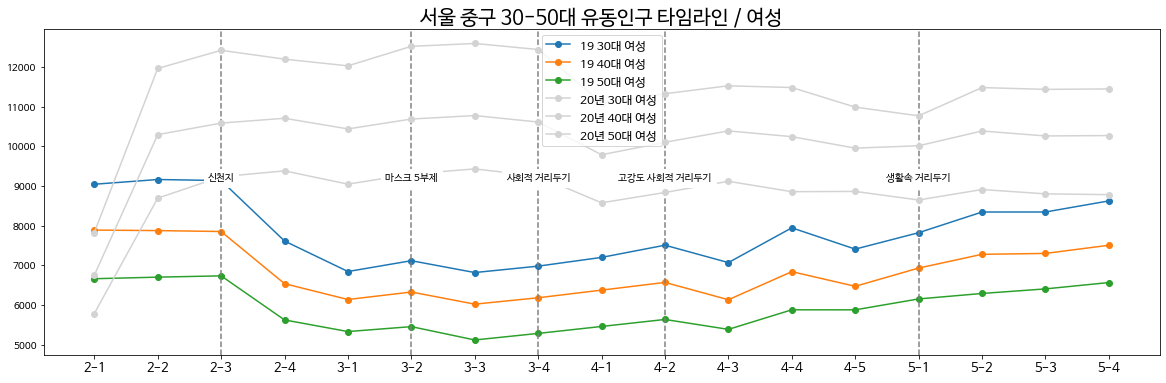

In [ ]:
fig = plt.figure(figsize=(20,6))

plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o', label="19 30대 여성")
plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_40_20, linestyle='-', marker='o', label="19 40대 여성")
plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o', label="19 50대 여성")

issue_line2(9200, 'grey')

plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="20년 30대 여성")
plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="20년 40대 여성")
plt.plot(ska_sj_ws_fw.index, ska_sj_ws_fw.WMN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="20년 50대 여성")

# plt.legend(['30대 남성', '40대 남성', '50대 남성'], loc='best', prop={'size': 14})
plt.legend(loc='best', prop={'size': 12})
plt.title('서울 중구 30-50대 유동인구 타임라인 / 여성', size=20)
plt.xticks(fontsize=13)

뒤에 회색이 2019년도인데, 유동 인구가 매우 줄어 들었음, 신천지 터진 이후로 계속 유동인구가 감소하고 유지되다가 생활속 거리 두기 이후에는 조금 늘어나긴 했음


- 주거 인구 많은 노원구, 10, 60-70U대 학생 및 노인 (여성) 확인

Text(0.5, 1.0, '서울 노원구 10대 & 60대 이상 유동인구 타임라인 / 여성')

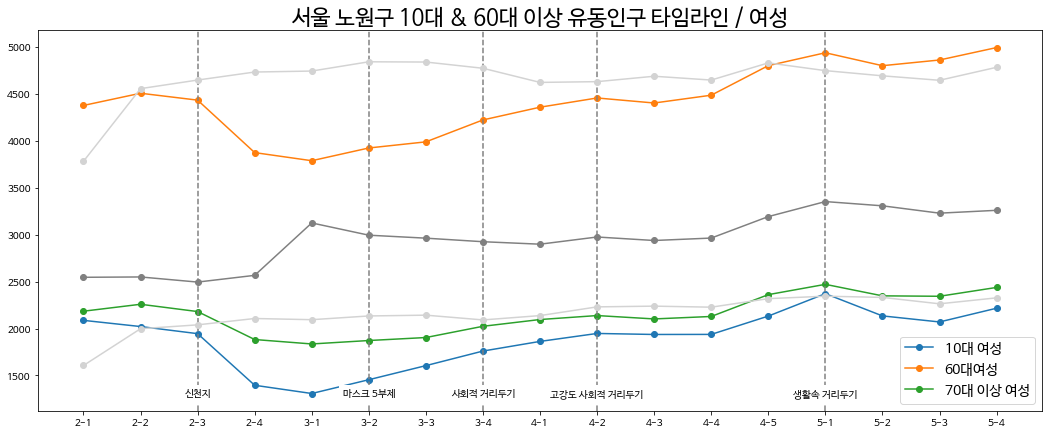

In [ ]:
fig = plt.figure(figsize=(18,7))

plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_10_20, linestyle='-', marker='o', label="value")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_60_20, linestyle='-', marker='o', label="value")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_70U_20, linestyle='-', marker='o', label="value")

issue_line2(1300, 'grey')

plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_10_19, linestyle='-', marker='o', color='grey', label="value")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_60_19, linestyle='-', marker='o', color='lightgrey', label="value")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_70U_19, linestyle='-', marker='o', color='lightgrey', label="value")

plt.legend(['10대 여성', '60대여성', '70대 이상 여성'], loc='best', prop={'size': 14})
plt.title('서울 노원구 10대 & 60대 이상 유동인구 타임라인 / 여성', size=22)

특이점은 60대 인구의 경우 코로나 발발 이전과 이후에 유동인구 폭이 상대적으로 좁은데 이는 주거 생활 지역이라서 불가피한 생활속 움직임이 있기 때문, 상대적으로 거동이 불편한 70대 또한 발발 이전과 이후의 폭이 매우 좁음, 거의 차이 없음, 다만 (2019년 진한 회색) 10대의 경우 유동인구 폭이 굉장히 많이 줄었음

- 놀거리가 많은 동성로가 있는 중구, 20-30대, 50대 - 서비스업 종사일수도 (여성) 확인

Text(0.5, 1.0, '대구 중구 20-30대 & 50대 유동인구 타임라인 / 여성')

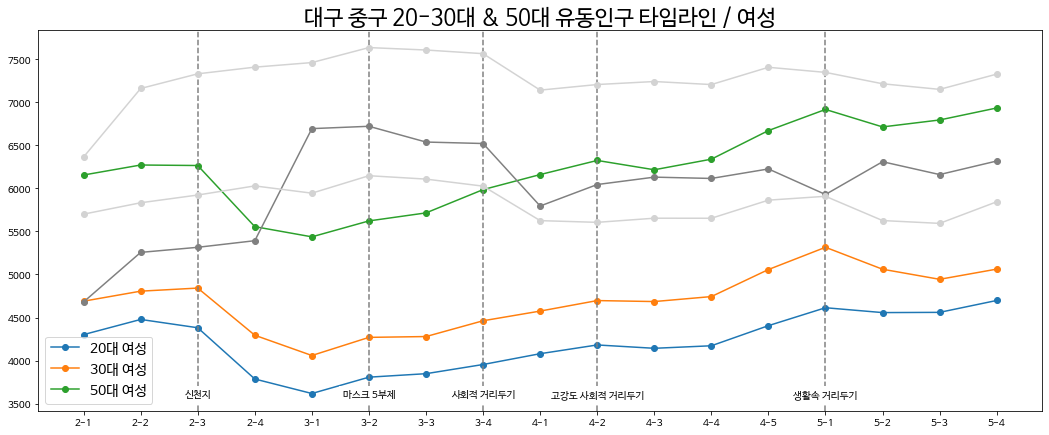

In [ ]:
fig = plt.figure(figsize=(18,7))

plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_20_20, linestyle='-', marker='o', label="value")
plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_30_20, linestyle='-', marker='o', label="value")
plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_50_20, linestyle='-', marker='o', label="value")

issue_line2(3600, 'grey')

plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_20_19, linestyle='-', marker='o', color='grey', label="value")
plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="value")
plt.plot(ska_dj_ws_fw.index, ska_dj_ws_fw.WMN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="value")

plt.legend(['20대 여성', '30대 여성', '50대 여성'], loc='best', prop={'size': 14})
plt.title('대구 중구 20-30대 & 50대 유동인구 타임라인 / 여성', size=22)

신천지 발발 이후 급격히 감소했으나 마스크 5부제 실시 이후 수도권 지역 위주로 확진자 수가 증가함에 따라 꾸준히 다시 증가. 사교와 유흥을 즐기는 세대(20-30)와 서비스 제공 세대(50대) 모두 비슷한 변화

- 교육열이 높기로 유명한 수성구, 10-30대 (남성)확인

Text(0.5, 1.0, '대구 수성구 10-30대 유동인구 타임라인 / 남성')

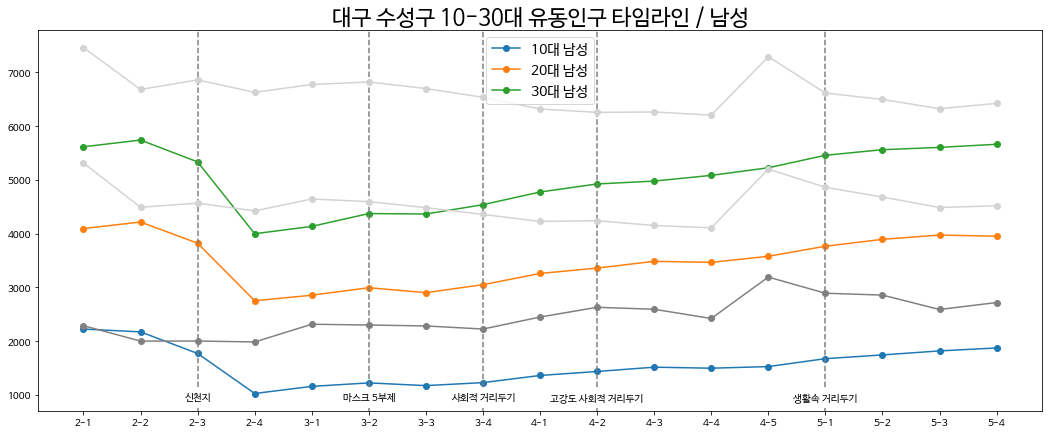

In [ ]:
fig = plt.figure(figsize=(18,7))

plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_10_20, linestyle='-', marker='o', label="value")
plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_20_20, linestyle='-', marker='o', label="value")
plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="value")

issue_line2(940, 'grey')

plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_10_19, linestyle='-', marker='o', color='grey', label="value")
plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_20_19, linestyle='-', marker='o', color='lightgrey', label="value")
plt.plot(ska_ds_ws_fm.index, ska_ds_ws_fm.MAN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="value")

plt.legend(['10대 남성', '20대 남성', '30대 남성'], loc='best', prop={'size': 14})
plt.title('대구 수성구 10-30대 유동인구 타임라인 / 남성', size=22)

(가장 진한 회색이 2019년) 10대 
<br>
중구랑 비교했을 때 교육열이 매우 높고 주거 지역인 수성구는 10-30대 모두 신천지 이후 유동인구가 감소했으나, 대구 중구의 추이는 아님, 꾸준히 2019년 유동인구를 회복하여 현재는 거의 비슷해짐


- 마지막으로 통틀어 정리하면, 서울은 노인 인구 외에 수도권 집중 감염으로 현재까지 앓고 있는 결과, 유동 인구는 아직 회복되지 않았다. (관광객이 많이 줄었기 때문으로도 보인다.)
<br>
- 반면 대구는 코로나 이전 유동인구를 거의 회복하고 있음을 알 수 있음.

=> 경제 활성화를 위해서는 어느정도 회복 필요, 그러나 혹시 모를 집단 감염에 매우 조심해야함

In [ ]:
ska_dj_ws_fm.head()

,MAN_CNT_00_19,MAN_CNT_10_19,MAN_CNT_20_19,MAN_CNT_30_19,MAN_CNT_40_19,MAN_CNT_50_19,MAN_CNT_60_19,MAN_CNT_70U_19,MAN_CNT_00_20,MAN_CNT_10_20,MAN_CNT_20_20,MAN_CNT_30_20,MAN_CNT_40_20,MAN_CNT_50_20,MAN_CNT_60_20,MAN_CNT_70U_20
2-1,150.256391,2595.405789,5262.558647,7403.749925,9176.989774,9466.074962,7378.098872,2883.983083,78.869549,2126.301053,4610.772782,6306.530226,8485.171805,8760.698271,6906.496466,3018.872782
2-2,111.641504,2408.021955,5515.241880,7716.260602,10223.446541,10732.973609,8696.094286,3529.093459,86.466692,2020.087744,4817.120677,6421.703459,8579.060977,8928.669398,7081.739173,3132.184737
2-3,123.488872,2393.272932,5662.444135,7939.581805,10419.243684,10907.609398,8830.257669,3555.405865,87.089323,1940.073759,4776.950752,6450.830602,8600.646015,8944.756767,7043.038872,3040.007669
2-4,145.443609,2527.123985,5751.440902,8024.230752,10554.407293,11122.860827,8881.516391,3645.788421,66.935789,1486.135414,4271.645188,6128.120677,8121.318421,8466.472406,6514.321203,2677.124361
3-1,123.330677,2930.907669,6448.638947,7998.745865,10591.648271,11028.805188,8828.386466,3574.239323,69.922632,1407.477368,4187.230376,5900.003083,7864.140752,8290.560752,6393.171805,2690.416466


(5000.0, 12000.0)

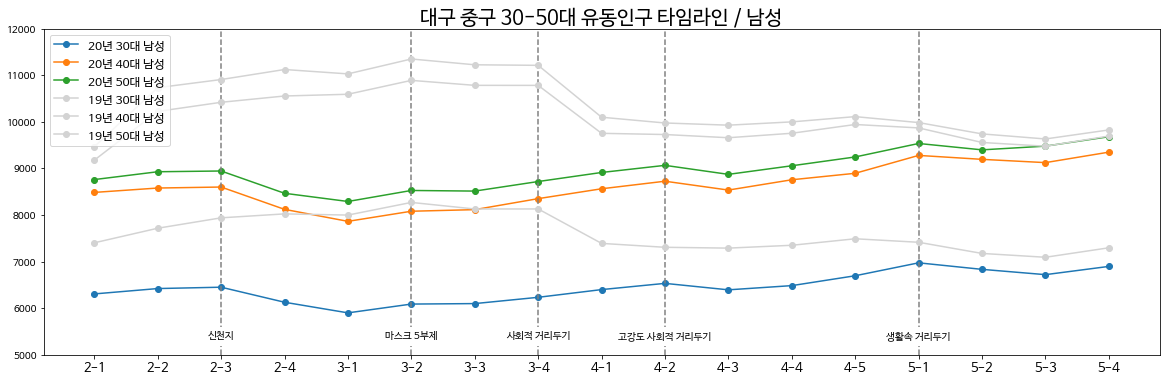

In [ ]:
# 대구 중구 30-50대 남성
fig = plt.figure(figsize=(20,6))

plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', label="20년 30대 남성")
plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', label="20년 40대 남성")
plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', label="20년 50대 남성")

issue_line2(5400, 'grey')

plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="19년 30대 남성")
plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="19년 40대 남성")
plt.plot(ska_dj_ws_fm.index, ska_dj_ws_fm.MAN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="19년 50대 남성")

plt.legend(loc='best', prop={'size': 12})
plt.title('대구 중구 30-50대 유동인구 타임라인 / 남성', size=20)
plt.xticks(fontsize=13)
plt.ylim(5000,12000)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text major ticklabel objects>)

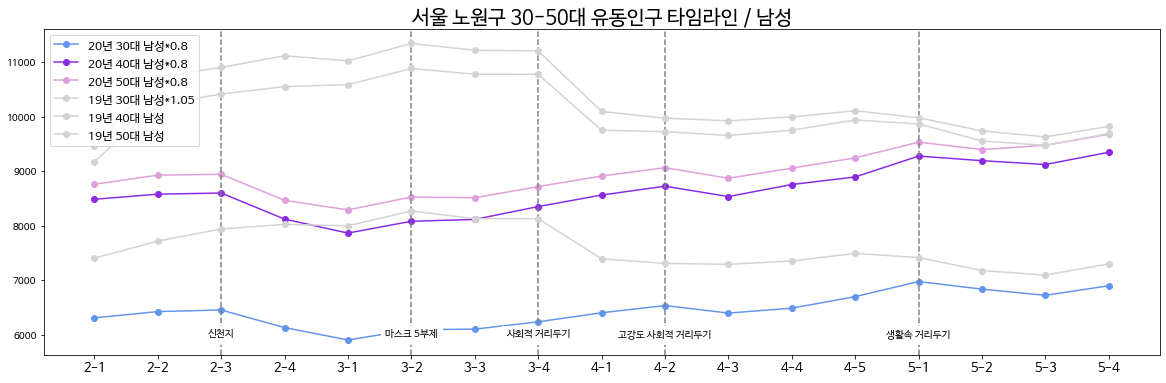

In [ ]:
# 노원구 30-50대 남성 *
fig = plt.figure(figsize=(20,6))

plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_30_20, linestyle='-', marker='o', color='#6495ED', label="20년 30대 남성*0.8")
plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_40_20, linestyle='-', marker='o', color='#8A2BE2',label="20년 40대 남성*0.8")
plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_50_20, linestyle='-', marker='o', color='#DDA0DD', label="20년 50대 남성*0.8")

issue_line2(6000, 'grey')

plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="19년 30대 남성*1.05")
plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="19년 40대 남성")
plt.plot(ska_nw_ws_fm.index, ska_nw_ws_fm.MAN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="19년 50대 남성")

plt.legend(loc='upper left', prop={'size': 12})
plt.title('서울 노원구 30-50대 유동인구 타임라인 / 남성', size=20)
plt.xticks(fontsize=13)

(2700.0, 9000.0)

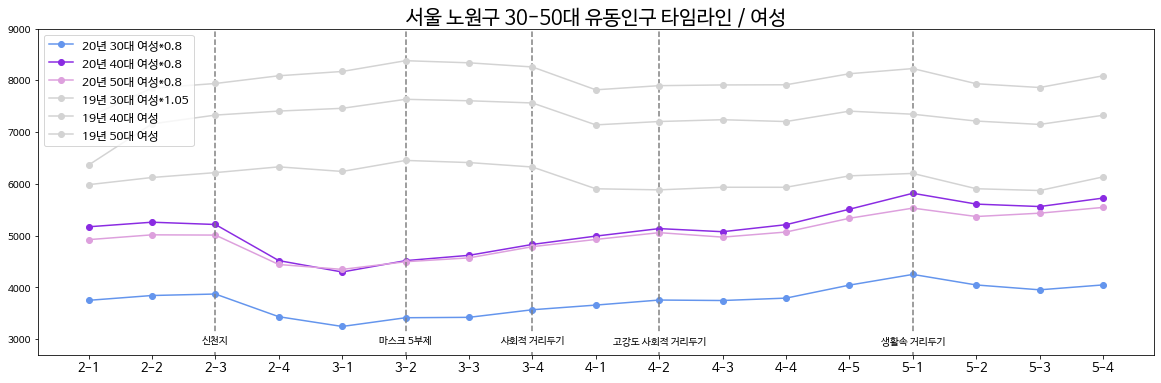

In [ ]:
# 노원구 30-50대 여성 *
fig = plt.figure(figsize=(20,6))

plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_30_20*0.8, linestyle='-', marker='o', color='#6495ED', label="20년 30대 여성*0.8")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_40_20*0.8, linestyle='-', marker='o', color='#8A2BE2',label="20년 40대 여성*0.8")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_50_20*0.8, linestyle='-', marker='o', color='#DDA0DD', label="20년 50대 여성*0.8")

issue_line2(2950, 'grey')

plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_30_19*1.05, linestyle='-', marker='o', color='lightgrey', label="19년 30대 여성*1.05")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="19년 40대 여성")
plt.plot(ska_nw_ws_fw.index, ska_nw_ws_fw.WMN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="19년 50대 여성")

plt.legend(loc='upper left', prop={'size': 12})
plt.title('서울 노원구 30-50대 유동인구 타임라인 / 여성', size=20)
plt.xticks(fontsize=13)
plt.ylim(2700,9000)

In [ ]:
ska_ds_ws_fw.head()

,WMN_CNT_00_19,WMN_CNT_10_19,WMN_CNT_20_19,WMN_CNT_30_19,WMN_CNT_40_19,WMN_CNT_50_19,WMN_CNT_60_19,WMN_CNT_70U_19,WMN_CNT_00_20,WMN_CNT_10_20,WMN_CNT_20_20,WMN_CNT_30_20,WMN_CNT_40_20,WMN_CNT_50_20,WMN_CNT_60_20,WMN_CNT_70U_20
2-1,186.050932,1963.077826,4267.508509,5493.335342,7484.718012,6310.162484,3467.396894,1467.115342,167.174845,2126.175280,3584.501677,4194.635404,7254.627267,6369.839255,4153.988820,2058.429193
2-2,163.073727,1777.049938,3852.273975,5009.172298,7838.470435,6849.684534,4055.608261,1787.783292,171.704161,2063.220932,3677.006335,4312.172547,7300.140124,6433.588075,4181.360683,2046.428634
2-3,186.067826,1801.065342,3980.058882,5146.908385,7938.377329,7027.539565,4136.075528,1795.614037,142.949193,1677.349255,3296.257329,3826.431677,6419.550932,5763.795031,3714.048199,1799.953665
2-4,199.388571,1797.603292,3875.452609,5001.850559,7428.523913,6586.589752,3914.302919,1712.064410,73.033168,966.870124,2229.553478,2554.545776,4465.930435,4181.775280,2606.158137,1248.760186
3-1,188.483478,2050.383913,4056.836460,5010.879565,7929.901553,6859.930000,4108.572857,1809.094596,85.363789,1044.723975,2355.880807,2709.833665,4749.854099,4411.906894,2766.103913,1315.198137


(700.0, 10000.0)

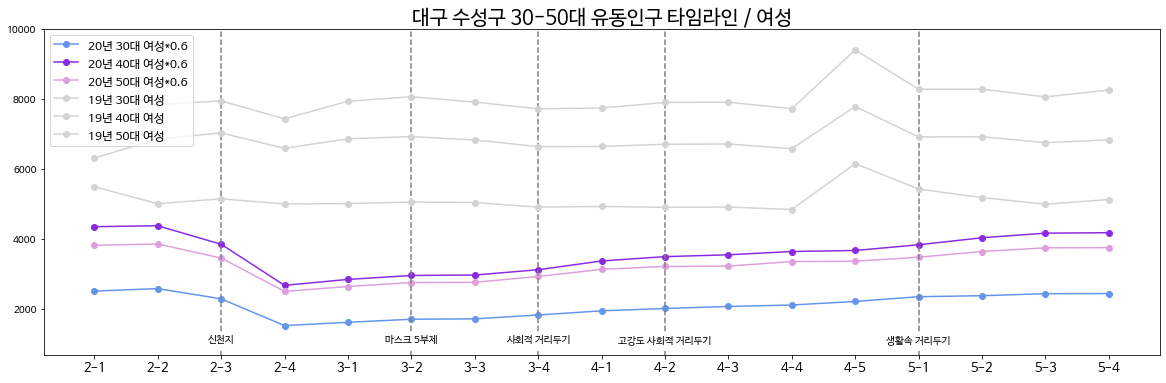

In [ ]:
# 수성구 30-50대 여성
fig = plt.figure(figsize=(20,6))

plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_30_20*0.6, linestyle='-', marker='o', color='#6495ED', label="20년 30대 여성*0.6")
plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_40_20*0.6, linestyle='-', marker='o', color='#8A2BE2', label="20년 40대 여성*0.6")
plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_50_20*0.6, linestyle='-', marker='o', color='#DDA0DD', label="20년 50대 여성*0.6")

issue_line2(1100, 'grey')

plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_30_19, linestyle='-', marker='o', color='lightgrey', label="19년 30대 여성")
plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_40_19, linestyle='-', marker='o', color='lightgrey', label="19년 40대 여성")
plt.plot(ska_ds_ws_fw.index, ska_ds_ws_fw.WMN_CNT_50_19, linestyle='-', marker='o', color='lightgrey', label="19년 50대 여성")

plt.title('대구 수성구 30-50대 유동인구 타임라인 / 여성', size=20)
plt.legend(loc='upper left', prop={'size': 12})
plt.xticks(fontsize=13)
plt.ylim(700,10000)

# **4. SK TMST 제공 데이터 EDA**

In [ ]:
sk = sk_backup
sk = sk.reset_index(drop=False)

sk['STD_Y'] = sk['STD_YMD'].dt.year
sk['STD_M'] = sk['STD_YMD'].dt.month

In [ ]:
# 구 및 지역 정보 추가
temp1 = sk['HDONG_CD'].astype(str).str.slice(start=0, stop=5)
temp2 = temp1

temp1 = temp1.apply(lambda x: '서울 중구' if x == '11140' else x)
temp1 = temp1.apply(lambda x: '서울 노원구' if x == '11350' else x)
temp1 = temp1.apply(lambda x: '대구 중구' if x == '27110' else x)
temp1 = temp1.apply(lambda x: '대구 수성구' if x == '27260' else x)
sk['HGU_NM'] = temp1

temp2 = temp2.apply(lambda x: '주거지구' if x in ['11140', '27110'] else x)
temp2 = temp2.apply(lambda x: '업무지구' if x in ['11350', '27260'] else x)
sk['DIT_NM'] = temp2 # district

In [ ]:
sk = sk.set_index(['DIT_NM', 'HGU_NM', 'STD_Y', 'STD_M'], drop=True) # index로 설정

sk_time = sk.iloc[:, 4:28]
sk_age_m = sk.iloc[:, 28:43]
sk_age_f = sk.iloc[:, 43:]

sk_time = sk_time.reset_index(drop=False)
sk_age_m = sk_age_m.reset_index(drop=False)
sk_age_f = sk_age_f.reset_index(drop=False)

sk_time = pd.melt(sk_time, id_vars=['DIT_NM', 'HGU_NM', 'STD_Y', 'STD_M'], var_name = 'TMST', value_name = 'TMST_NUM')
sk_age_m = pd.melt(sk_age_m, id_vars=['DIT_NM', 'HGU_NM', 'STD_Y', 'STD_M'], var_name = 'AGE_M', value_name = 'AGE_M_NUM')
sk_age_f = pd.melt(sk_age_f, id_vars=['DIT_NM', 'HGU_NM', 'STD_Y', 'STD_M'], var_name = 'AGE_F', value_name = 'AGE_F_NUM')

In [ ]:
sk_time['TMST'] = sk_time['TMST'].astype(str).str.slice(start=5, stop=7).astype(int)
sk_time_g = sk_time.groupby(['DIT_NM', 'HGU_NM', 'STD_Y', 'STD_M', 'TMST']).sum()
sk_time_g = sk_time_g.reset_index(drop=False)
sk_time_g_byt = sk_time_g.groupby(['DIT_NM', 'TMST']).sum()

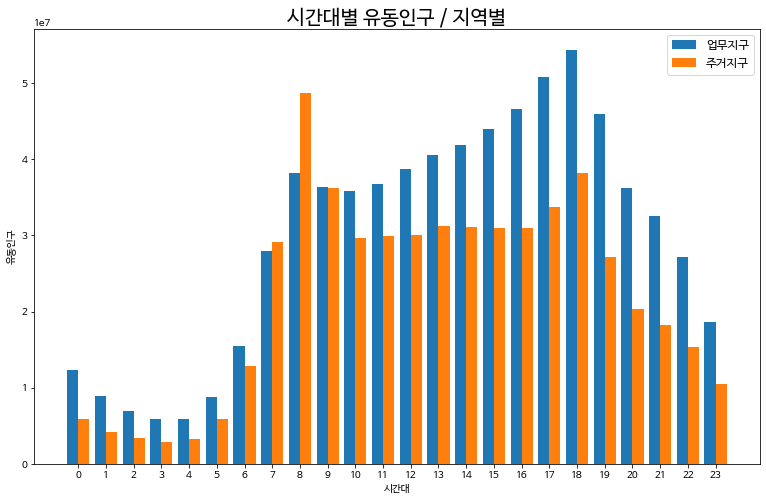

In [ ]:
fig = plt.figure(figsize=(13,8))

plt.bar(sk_time_g_byt.loc['업무지구'].index - 0.2, sk_time_g_byt.loc['업무지구'].TMST_NUM, label='업무지구', width=0.4)
plt.bar(sk_time_g_byt.loc['주거지구'].index + 0.2, sk_time_g_byt.loc['주거지구'].TMST_NUM, label='주거지구', width=0.4)
plt.xlabel('시간대')
plt.ylabel('유동인구')
plt.xticks(np.arange(0, 24, step=1))
plt.title('시간대별 유동인구 / 지역별', size=20)
plt.legend(prop={'size': 12})

plt.show()

주거지역에서 8시와 오후 6시에 급격히 유동인구가 늘어남, 이는 직장 출근과 퇴근에 의함. 그 외에는 항상 업무 지구의 유동인구가 많으며 주로 업무 지구에는 직장인들의 회식 등을 할 수 있는 상권이 발달하기 마련, 늦게까지 상권이나 회사 주변에 유동인구가 많다. 

In [ ]:
sk_time_g_bygt = sk_time_g.groupby(['HGU_NM', 'TMST']).sum()

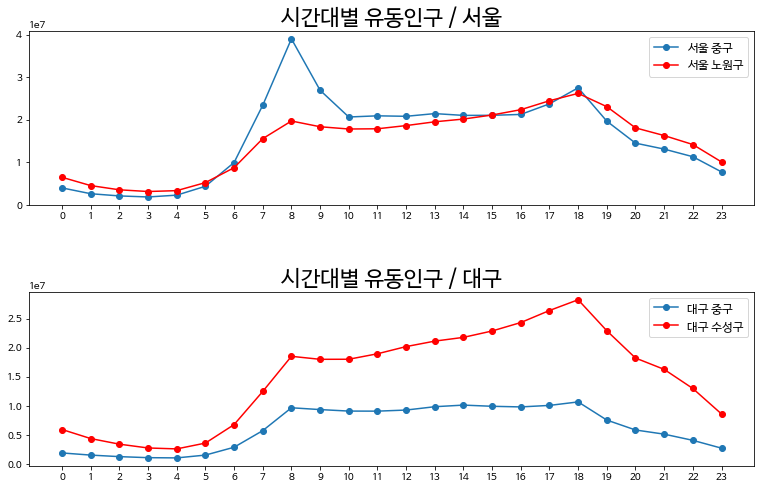

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(13, 8))
plt.subplots_adjust(hspace = 0.5) # hspace = 0.2

ax1.plot(sk_time_g_bygt.loc['서울 중구'].index, sk_time_g_bygt.loc['서울 중구'].TMST_NUM, linestyle='-', marker='o', label="서울 중구")
ax1.plot(sk_time_g_bygt.loc['서울 노원구'].index, sk_time_g_bygt.loc['서울 노원구'].TMST_NUM, linestyle='-', color='r', marker='o', label="서울 노원구")
ax1.set_title('시간대별 유동인구 / 서울', fontsize=22)
ax1.legend(prop={'size': 12})

ax2.plot(sk_time_g_bygt.loc['대구 중구'].index, sk_time_g_bygt.loc['대구 중구'].TMST_NUM, linestyle='-', marker='o', label="대구 중구")
ax2.plot(sk_time_g_bygt.loc['대구 수성구'].index, sk_time_g_bygt.loc['대구 수성구'].TMST_NUM, linestyle='-', color='r', marker='o', label="대구 수성구")
ax2.set_title('시간대별 유동인구 / 대구', fontsize=22)
ax2.legend(prop={'size': 12})

 # 특정 plot 선택, ax로 정의하고 ax[0, 1] or ax[0] 이런 것도 방법
plt.sca(ax1)
plt.xticks(range(24))

plt.sca(ax2)
plt.xticks(range(24))

plt.show()

In [ ]:
sk_time_g_bydy = sk_time_g.groupby(['DIT_NM', 'STD_Y', 'TMST']).sum()

In [ ]:
sk_time_g_bydy.loc['업무지구'].loc[2019].index-0.2

Float64Index([-0.2,  0.8,  1.8,  2.8,  3.8,  4.8,  5.8,  6.8,  7.8,  8.8,  9.8,
              10.8, 11.8, 12.8, 13.8, 14.8, 15.8, 16.8, 17.8, 18.8, 19.8, 20.8,
              21.8, 22.8],
             dtype='float64', name='TMST')

# **PPT 최종 사용 graph**

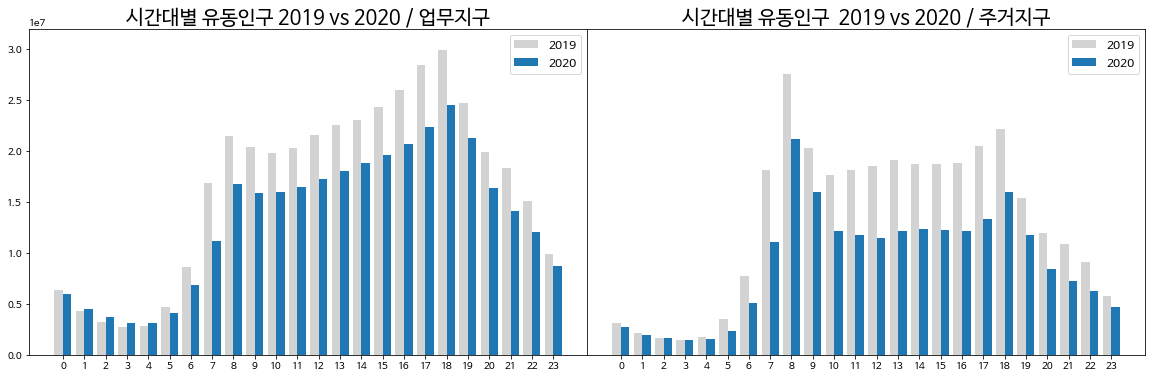

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
plt.subplots_adjust(wspace = 0) # hspace = 0.2

ax1.bar(sk_time_g_bydy.loc['업무지구'].loc[2019].index-0.2, sk_time_g_bydy.loc['업무지구'].loc[2019].TMST_NUM, width=0.4, color = 'lightgrey', label="2019")
ax1.bar(sk_time_g_bydy.loc['업무지구'].loc[2020].index+0.2, sk_time_g_bydy.loc['업무지구'].loc[2020].TMST_NUM, width=0.4, label="2020")
ax1.set_title('시간대별 유동인구 2019 vs 2020 / 업무지구', fontsize=20)
ax1.legend(prop={'size': 12})

ax2.bar(sk_time_g_bydy.loc['주거지구'].loc[2019].index-0.2, sk_time_g_bydy.loc['주거지구'].loc[2019].TMST_NUM, width=0.4, color = 'lightgrey', label="2019")
ax2.bar(sk_time_g_bydy.loc['주거지구'].loc[2020].index+0.2, sk_time_g_bydy.loc['주거지구'].loc[2020].TMST_NUM, width=0.4, label="2020")
ax2.set_title('시간대별 유동인구  2019 vs 2020 / 주거지구', fontsize=20)
ax2.legend(prop={'size': 12})

 # 특정 plot 선택, ax로 정의하고 ax[0, 1] or ax[0] 이런 것도 방법
plt.sca(ax1)
plt.xticks(range(24))
plt.ylim(0,3.2*1e7)

plt.sca(ax2)
plt.xticks(range(24))
plt.ylim(0,3.2*1e7)
plt.yticks([])

plt.show()